Nonlinearity Analysis Results

Analyzing: Linear
------------------------------
Local PCA Deviation: 0.049802
Isomap Residual Variance: 0.010631
Geodesic-Euclidean Correlation: 0.994670
Trustworthiness: 0.363800
Continuity: 0.363800


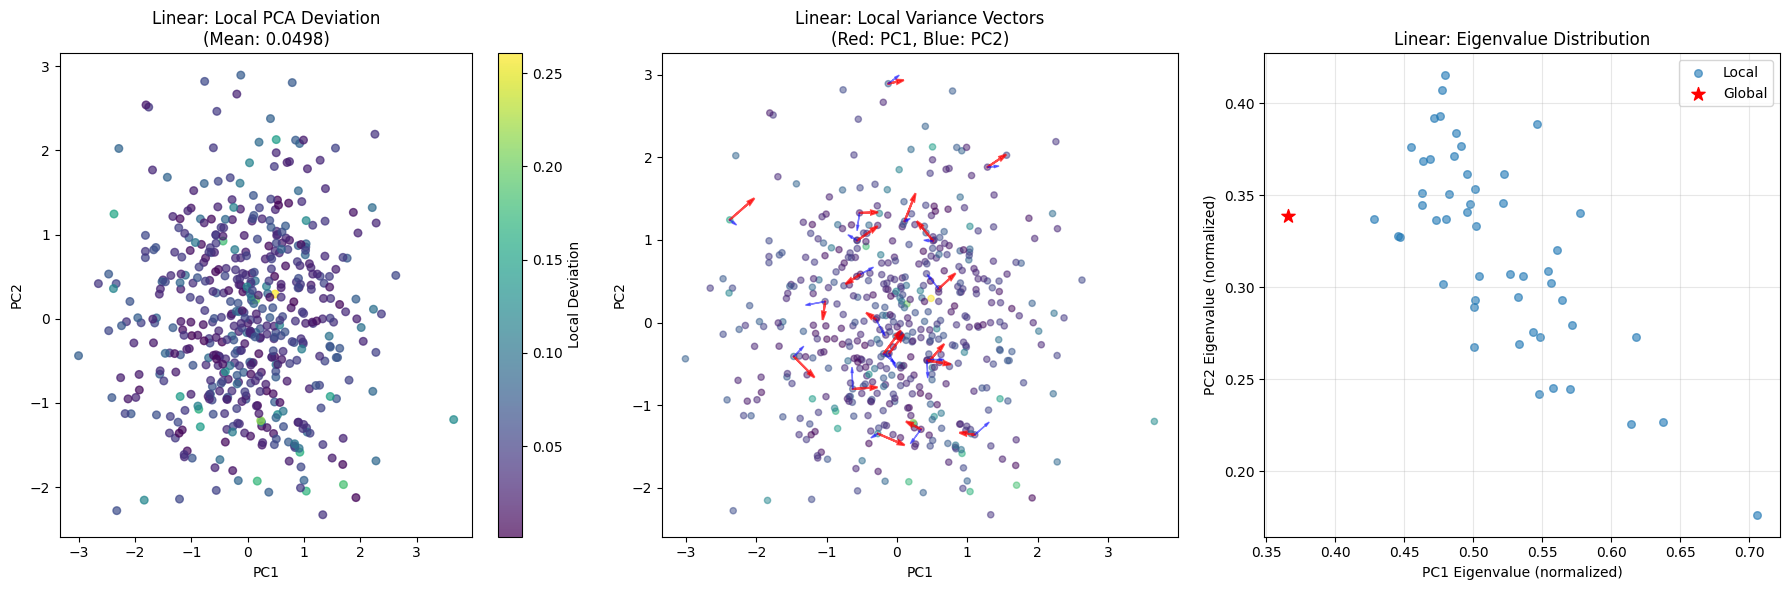


Analyzing: Swiss Roll
------------------------------
Local PCA Deviation: 0.136421
Isomap Residual Variance: 0.311737
Geodesic-Euclidean Correlation: 0.829616
Trustworthiness: 0.390000
Continuity: 0.390000


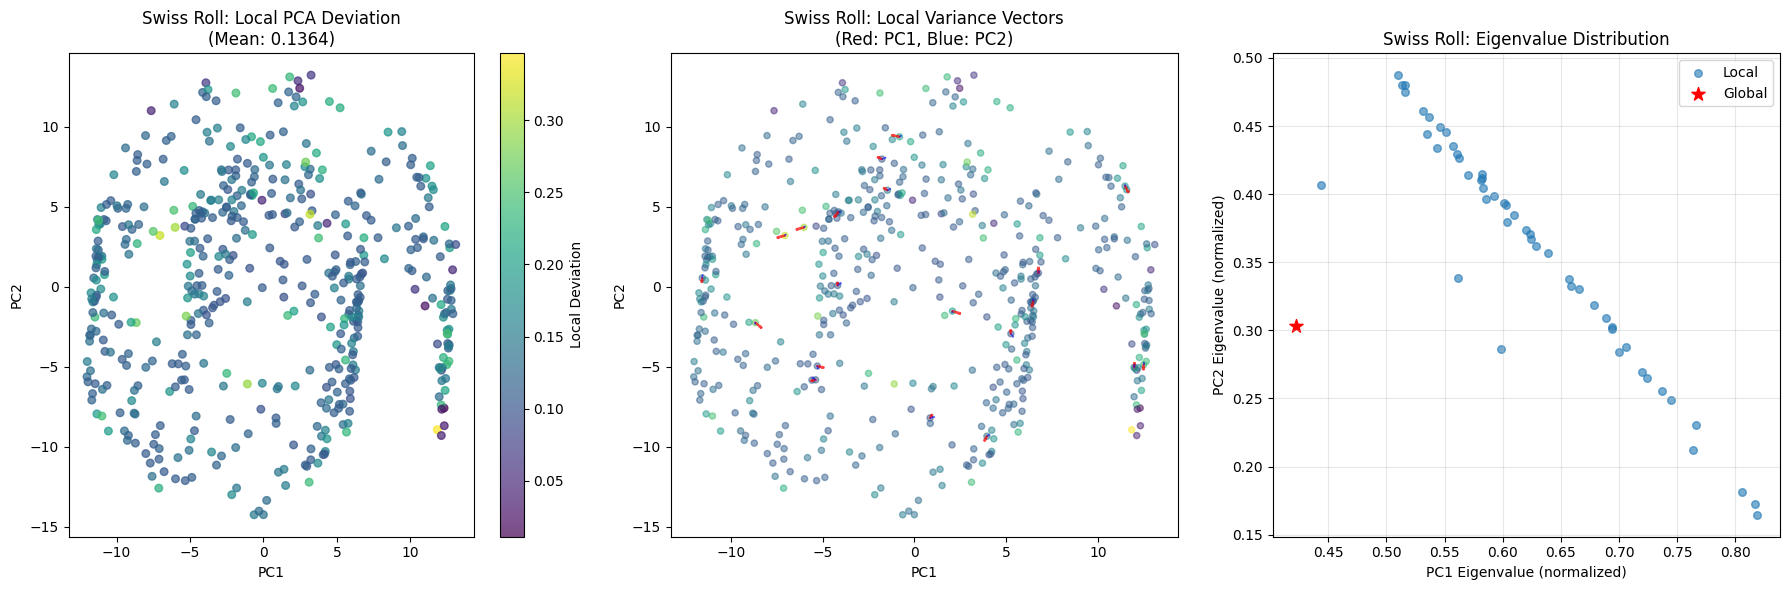


Analyzing: S-curve
------------------------------
Local PCA Deviation: 0.037297
Isomap Residual Variance: 0.255200
Geodesic-Euclidean Correlation: 0.863018
Trustworthiness: 0.816400
Continuity: 0.816400


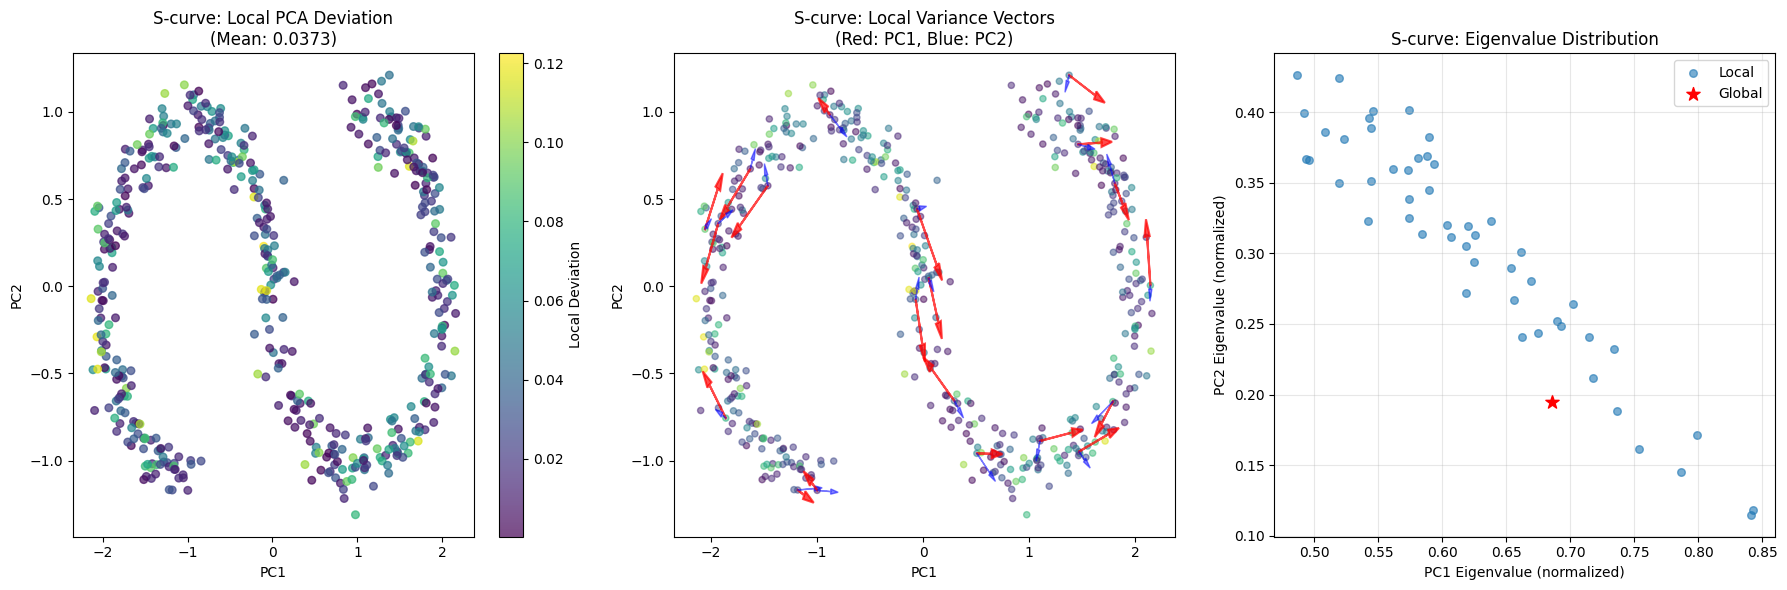


Analyzing: Circles
------------------------------
Local PCA Deviation: 0.077013
Isomap Residual Variance: 0.017327
Geodesic-Euclidean Correlation: 0.991298
Trustworthiness: 0.743200
Continuity: 0.743200


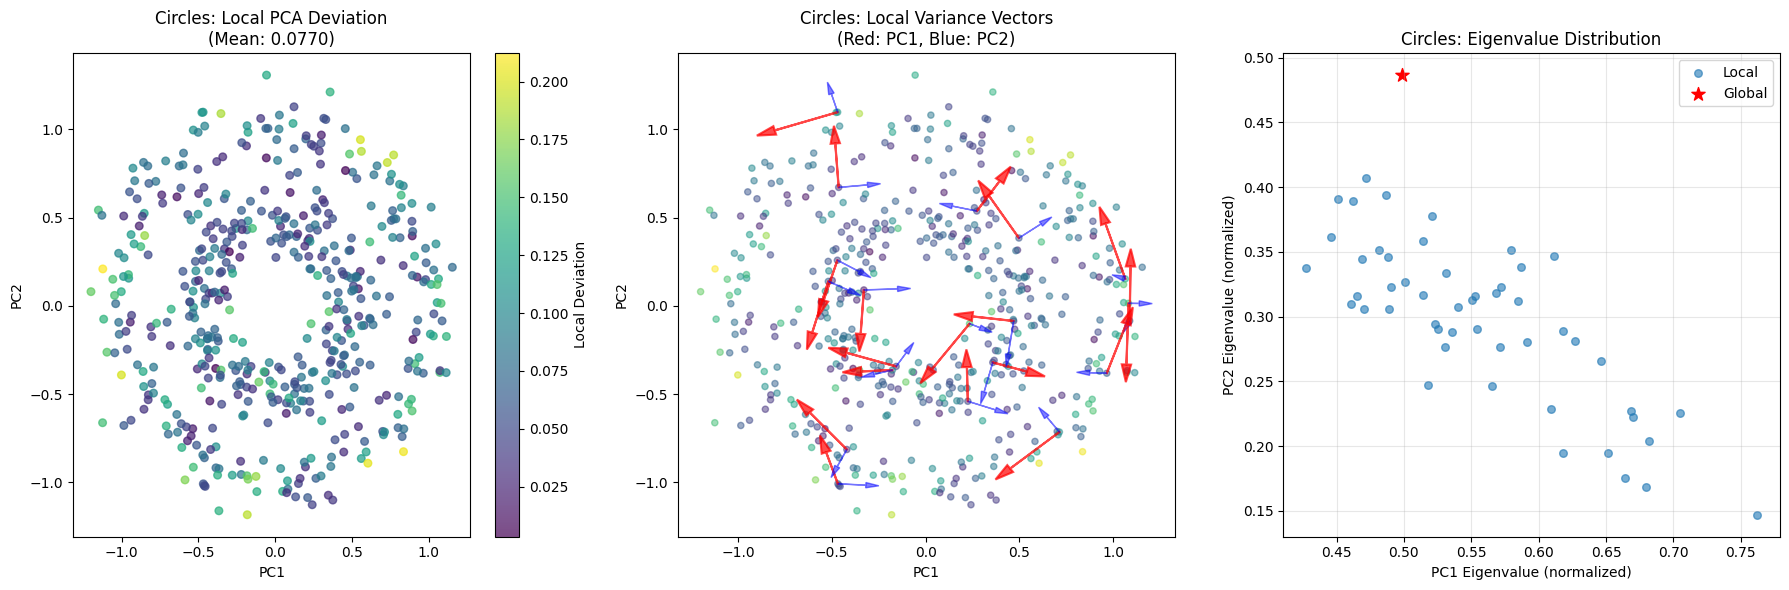


Analyzing: Moons
------------------------------
Local PCA Deviation: 0.110440
Isomap Residual Variance: 0.264965
Geodesic-Euclidean Correlation: 0.857342
Trustworthiness: 0.568800
Continuity: 0.568800


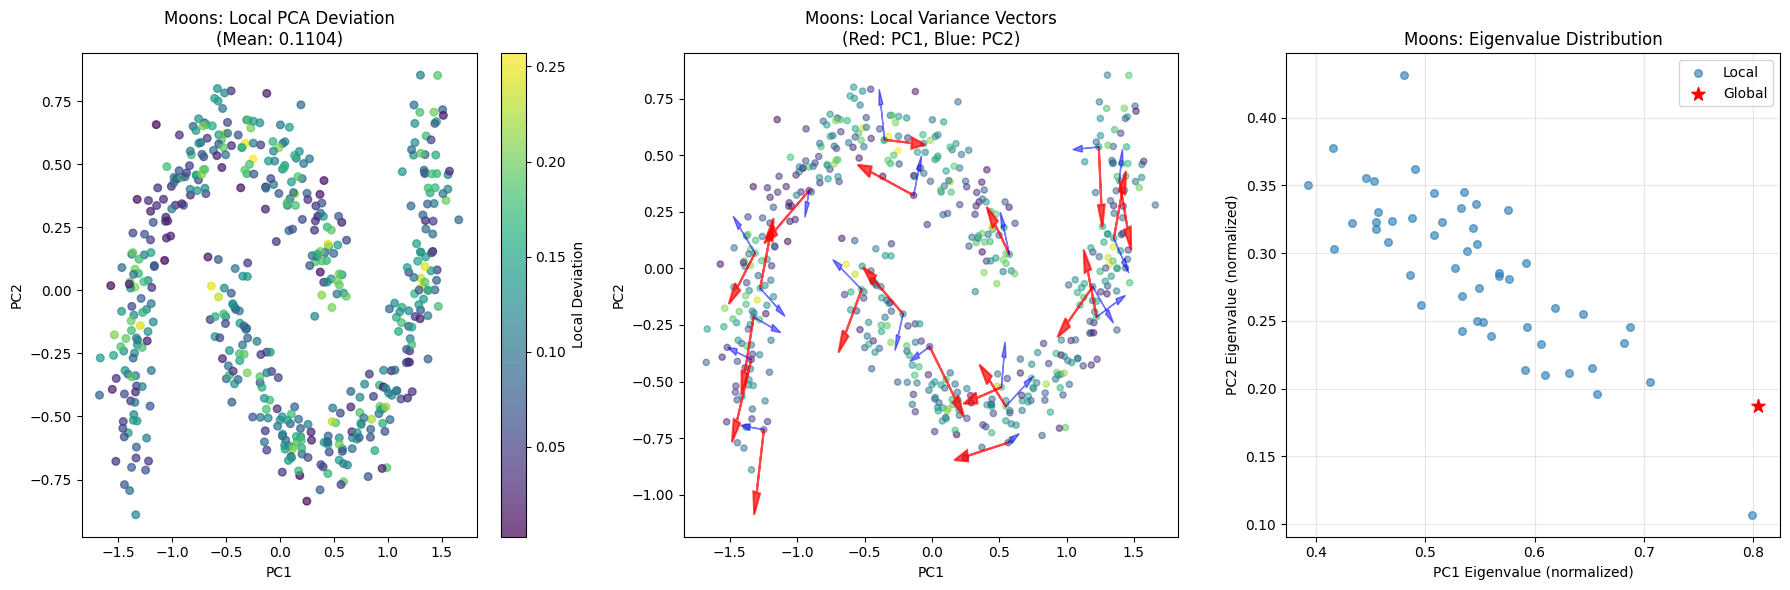


Analyzing: Helix
------------------------------
Local PCA Deviation: 0.028188
Isomap Residual Variance: 0.375377
Geodesic-Euclidean Correlation: 0.790331
Trustworthiness: 0.718200
Continuity: 0.718200


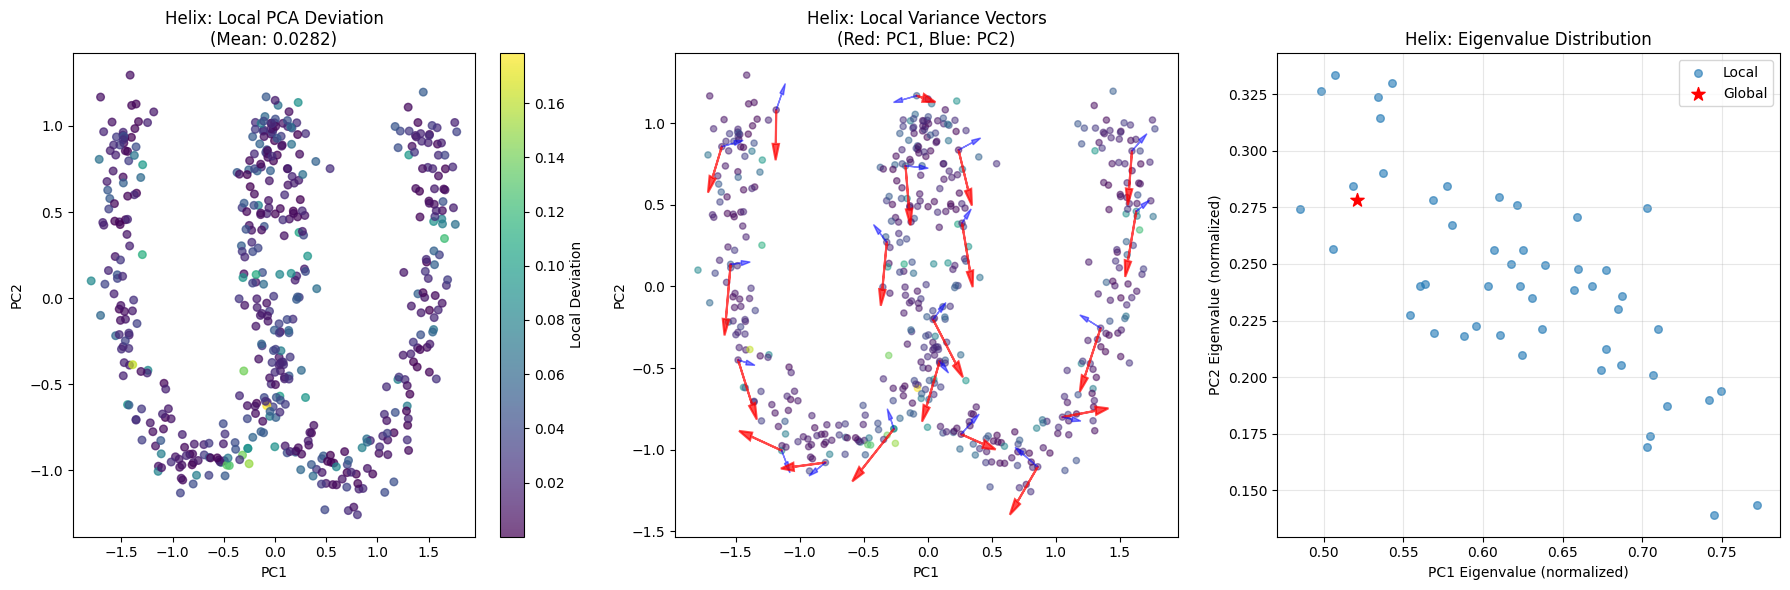


CORRELATION ANALYSIS
Local PCA Deviation vs Isomap Residual: 0.1004
Local PCA Deviation vs (1-Trustworthiness): 0.5224
Local PCA Deviation vs Combined Nonlinearity: 0.5152


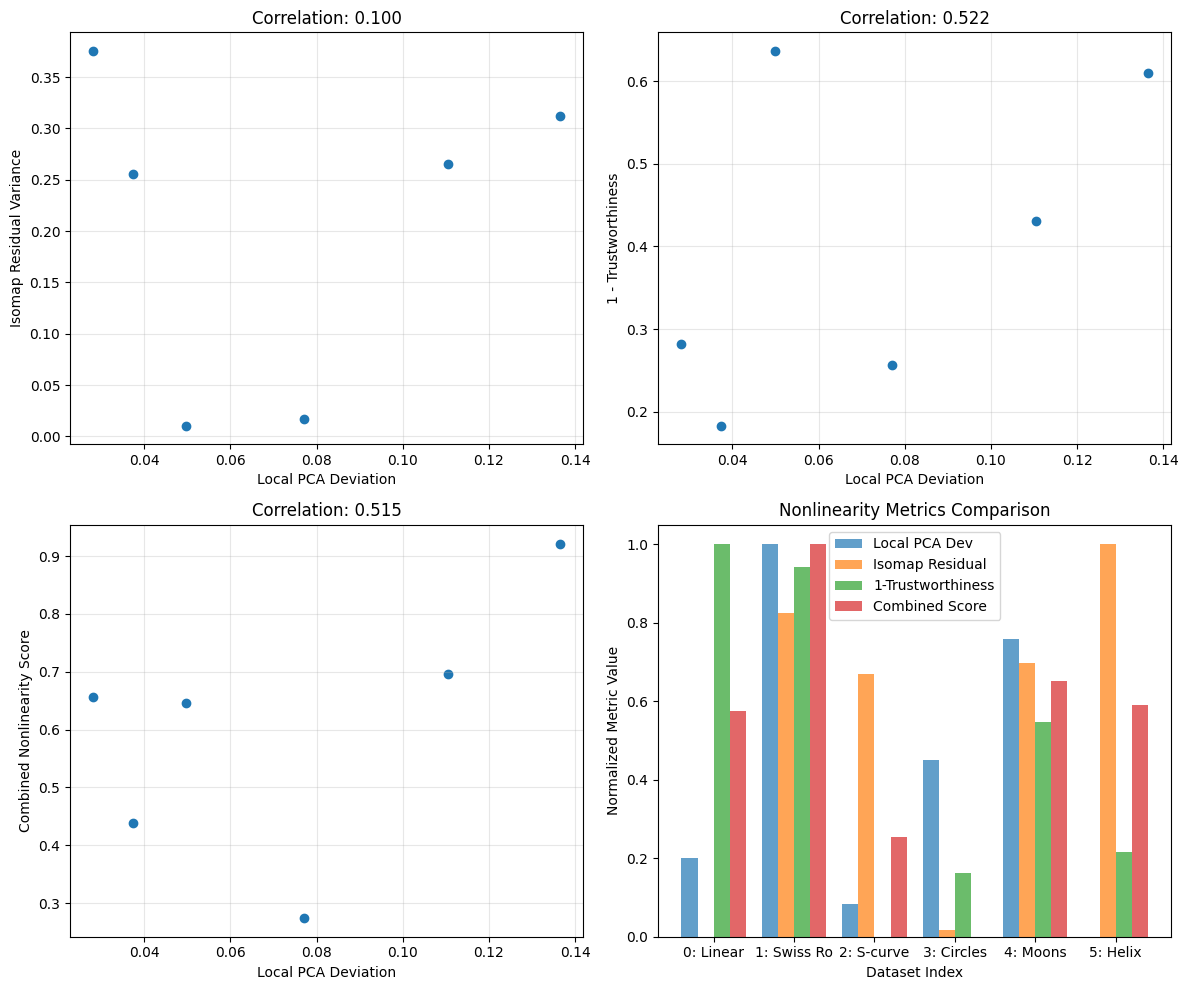


SUMMARY TABLE
--------------------------------------------------------------------------------
Dataset      Local PCA    Isomap Res   Trust    Cont     Combined  
--------------------------------------------------------------------------------
Linear       0.049802     0.010631     0.3638   0.3638   0.646831  
Swiss Roll   0.136421     0.311737     0.3900   0.3900   0.921737  
S-curve      0.037297     0.255200     0.8164   0.8164   0.438800  
Circles      0.077013     0.017327     0.7432   0.7432   0.274127  
Moons        0.110440     0.264965     0.5688   0.5688   0.696165  
Helix        0.028188     0.375377     0.7182   0.7182   0.657177  


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_s_curve, make_circles, make_moons
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import warnings
warnings.filterwarnings('ignore')

class NonlinearityAnalyzer:
    def __init__(self, k_neighbors=10, epsilon=1e-8):
        """
        Initialize the nonlinearity analyzer
        
        Parameters:
        k_neighbors: number of nearest neighbors for local PCA
        epsilon: numerical stability parameter
        """
        self.k_neighbors = k_neighbors
        self.epsilon = epsilon
        
    def compute_global_pca(self, X):
        """Compute global PCA statistics"""
        # Center the data
        X_centered = X - np.mean(X, axis=0)
        
        # Compute covariance matrix
        cov_global = np.cov(X_centered.T)
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_global)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_global
    
    def compute_local_pca(self, X, point_idx, neighbors_idx):
        """Compute local PCA for a specific point and its neighbors"""
        # Get local neighborhood
        X_local = X[neighbors_idx]
        
        # Center local data
        X_local_centered = X_local - np.mean(X_local, axis=0)
        
        # Compute local covariance
        if len(X_local) > 1:
            cov_local = np.cov(X_local_centered.T)
        else:
            cov_local = np.zeros((X.shape[1], X.shape[1]))
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_local)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_local
    
    def local_pca_deviation(self, X):
        """
        Compute the Local PCA Deviation metric
        
        This is the main metric from the paper:
        LocalPCADeviation = (1/n) * sum_i sum_k (lambda_k^(i) - lambda_k)^2
        """
        n_points, n_dims = X.shape
        
        # Find k-nearest neighbors for each point
        nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, n_points)).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Compute global PCA
        global_eigenvals_norm, global_eigenvecs, global_cov = self.compute_global_pca(X)
        
        # Compute local deviations
        local_deviations = []
        local_eigenvals_all = []
        local_eigenvecs_all = []
        
        for i in range(n_points):
            # Get neighbors (excluding the point itself)
            neighbors_idx = indices[i][1:]  # Skip first element (the point itself)
            
            # Compute local PCA
            local_eigenvals_norm, local_eigenvecs, local_cov = self.compute_local_pca(X, i, neighbors_idx)
            
            # Compute squared differences between local and global normalized eigenvalues
            deviation = np.sum((local_eigenvals_norm - global_eigenvals_norm) ** 2)
            
            local_deviations.append(deviation)
            local_eigenvals_all.append(local_eigenvals_norm)
            local_eigenvecs_all.append(local_eigenvecs)
        
        # Average deviation across all points
        mean_deviation = np.mean(local_deviations)
        
        return {
            'mean_deviation': mean_deviation,
            'point_deviations': np.array(local_deviations),
            'global_eigenvals': global_eigenvals_norm,
            'global_eigenvecs': global_eigenvecs,
            'local_eigenvals': local_eigenvals_all,
            'local_eigenvecs': local_eigenvecs_all,
            'neighbor_indices': indices
        }
    
    def isomap_residual_variance(self, X, n_components=2):
        """
        Compute Isomap residual variance as reference nonlinearity metric
        Measures how well geodesic distances are preserved in Euclidean embedding
        """
        # Compute Isomap embedding
        isomap = Isomap(n_components=n_components, n_neighbors=self.k_neighbors)
        X_embedded = isomap.fit_transform(X)
        
        # Get geodesic distance matrix
        geodesic_distances = isomap.dist_matrix_
        
        # Compute Euclidean distances in original space
        euclidean_distances = pairwise_distances(X)
        
        # Flatten distance matrices (only upper triangle to avoid duplicates)
        mask = np.triu(np.ones_like(geodesic_distances, dtype=bool), k=1)
        geo_flat = geodesic_distances[mask]
        euc_flat = euclidean_distances[mask]
        
        # Compute correlation coefficient
        correlation, _ = pearsonr(geo_flat, euc_flat)
        
        # Residual variance = 1 - R^2
        residual_variance = 1 - correlation**2
        
        return residual_variance, X_embedded, correlation
    
    def trustworthiness_continuity(self, X, X_embedded, k=10):
        """
        Compute trustworthiness and continuity metrics
        Another reference for nonlinearity assessment
        """
        n_points = X.shape[0]
        
        # Compute k-nearest neighbors in original space
        nbrs_orig = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, indices_orig = nbrs_orig.kneighbors(X)
        
        # Compute k-nearest neighbors in embedded space
        nbrs_emb = NearestNeighbors(n_neighbors=k+1).fit(X_embedded)
        _, indices_emb = nbrs_emb.kneighbors(X_embedded)
        
        # Trustworthiness: are embedded neighbors true neighbors?
        trustworthiness = 0
        for i in range(n_points):
            orig_neighbors = set(indices_orig[i][1:])  # exclude point itself
            emb_neighbors = set(indices_emb[i][1:])
            
            # Count how many embedded neighbors are also original neighbors
            trustworthiness += len(orig_neighbors.intersection(emb_neighbors)) / k
        
        trustworthiness /= n_points
        
        # Continuity: are original neighbors preserved in embedding?
        continuity = 0
        for i in range(n_points):
            orig_neighbors = set(indices_orig[i][1:])
            emb_neighbors = set(indices_emb[i][1:])
            
            # Count how many original neighbors are also embedded neighbors
            continuity += len(orig_neighbors.intersection(emb_neighbors)) / k
        
        continuity /= n_points
        
        return trustworthiness, continuity

def generate_test_datasets():
    """Generate various test datasets with different nonlinearity characteristics"""
    datasets = {}
    
    # 1. Linear data (should have low nonlinearity)
    np.random.seed(42)
    linear_data = np.random.randn(500, 3)
    datasets['Linear'] = linear_data
    
    # 2. Swiss Roll (high nonlinearity)
    swiss_roll, color = make_swiss_roll(n_samples=500, noise=0.1, random_state=42)
    datasets['Swiss Roll'] = swiss_roll
    
    # 3. S-curve (medium nonlinearity)
    s_curve, color = make_s_curve(n_samples=500, noise=0.1, random_state=42)
    datasets['S-curve'] = s_curve
    
    # 4. Circles (2D nonlinear)
    circles, _ = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
    # Embed in 3D
    circles_3d = np.column_stack([circles, np.random.randn(500) * 0.1])
    datasets['Circles'] = circles_3d
    
    # 5. Moons (2D nonlinear)
    moons, _ = make_moons(n_samples=500, noise=0.1, random_state=42)
    # Embed in 3D
    moons_3d = np.column_stack([moons, np.random.randn(500) * 0.1])
    datasets['Moons'] = moons_3d
    
    # 6. Helix (highly nonlinear)
    t = np.linspace(0, 4*np.pi, 500)
    helix = np.column_stack([
        np.cos(t) + 0.1*np.random.randn(500),
        np.sin(t) + 0.1*np.random.randn(500),
        t/4 + 0.1*np.random.randn(500)
    ])
    datasets['Helix'] = helix
    
    return datasets

def visualize_local_variance_vectors_2d(X, results, dataset_name, n_arrows=20):
    """
    Create 2D visualization showing local variance vectors
    """
    # Project to 2D using PCA for visualization
    pca_2d = PCA(n_components=2)
    X_2d = pca_2d.fit_transform(X)
    
    # Get local eigenvectors in 2D space
    # Transform eigenvectors to 2D space
    local_eigenvecs_2d = []
    for eigenvecs in results['local_eigenvecs']:
        # Project the first two eigenvectors to 2D space
        eigenvecs_2d = pca_2d.components_ @ eigenvecs[:, :2]
        local_eigenvecs_2d.append(eigenvecs_2d)
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Data colored by local deviation
    scatter = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], 
                             c=results['point_deviations'], 
                             cmap='viridis', s=30, alpha=0.7)
    axes[0].set_title(f'{dataset_name}: Local PCA Deviation\n(Mean: {results["mean_deviation"]:.4f})')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    plt.colorbar(scatter, ax=axes[0], label='Local Deviation')
    
    # Plot 2: Local variance vectors
    # Select points to show arrows (avoid overcrowding)
    step = max(1, len(X_2d) // n_arrows)
    selected_indices = np.arange(0, len(X_2d), step)
    
    axes[1].scatter(X_2d[:, 0], X_2d[:, 1], 
                   c=results['point_deviations'], 
                   cmap='viridis', s=20, alpha=0.5)
    
    # Draw local principal component vectors
    scale_factor = 0.5
    for idx in selected_indices:
        x, y = X_2d[idx]
        
        # First principal component (scaled by eigenvalue)
        if len(local_eigenvecs_2d[idx]) > 0 and len(results['local_eigenvals'][idx]) > 0:
            pc1_2d = local_eigenvecs_2d[idx][:, 0] * results['local_eigenvals'][idx][0] * scale_factor
            pc2_2d = local_eigenvecs_2d[idx][:, 1] * results['local_eigenvals'][idx][1] * scale_factor
            
            # Draw arrows for first two components
            axes[1].arrow(x, y, pc1_2d[0], pc1_2d[1], 
                         head_width=0.05, head_length=0.1, 
                         fc='red', ec='red', alpha=0.7, linewidth=1.5)
            axes[1].arrow(x, y, pc2_2d[0], pc2_2d[1], 
                         head_width=0.03, head_length=0.07, 
                         fc='blue', ec='blue', alpha=0.5, linewidth=1)
    
    axes[1].set_title(f'{dataset_name}: Local Variance Vectors\n(Red: PC1, Blue: PC2)')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    
    # Plot 3: Global vs Local eigenvalue comparison
    n_points = len(results['local_eigenvals'])
    sample_points = np.random.choice(n_points, min(50, n_points), replace=False)
    
    local_pc1_vals = [results['local_eigenvals'][i][0] for i in sample_points]
    local_pc2_vals = [results['local_eigenvals'][i][1] for i in sample_points]
    
    axes[2].scatter(local_pc1_vals, local_pc2_vals, alpha=0.6, s=30, label='Local')
    axes[2].scatter([results['global_eigenvals'][0]], [results['global_eigenvals'][1]], 
                   color='red', s=100, marker='*', label='Global')
    axes[2].set_xlabel('PC1 Eigenvalue (normalized)')
    axes[2].set_ylabel('PC2 Eigenvalue (normalized)')
    axes[2].set_title(f'{dataset_name}: Eigenvalue Distribution')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def run_comprehensive_analysis():
    """Run comprehensive nonlinearity analysis on multiple datasets"""
    
    # Generate datasets
    datasets = generate_test_datasets()
    
    # Initialize analyzer
    analyzer = NonlinearityAnalyzer(k_neighbors=15)
    
    # Store results
    results_summary = []
    
    print("Nonlinearity Analysis Results")
    print("=" * 50)
    
    for name, data in datasets.items():
        print(f"\nAnalyzing: {name}")
        print("-" * 30)
        
        # Compute Local PCA Deviation
        local_pca_results = analyzer.local_pca_deviation(data)
        
        # Compute reference metrics
        isomap_residual, data_embedded, correlation = analyzer.isomap_residual_variance(data)
        trustworthiness, continuity = analyzer.trustworthiness_continuity(data, data_embedded)
        
        # Store results
        result = {
            'dataset': name,
            'local_pca_deviation': local_pca_results['mean_deviation'],
            'isomap_residual_variance': isomap_residual,
            'geodesic_euclidean_correlation': correlation,
            'trustworthiness': trustworthiness,
            'continuity': continuity,
            'nonlinearity_score': (1 - trustworthiness) + isomap_residual  # Combined reference
        }
        results_summary.append(result)
        
        # Print results
        print(f"Local PCA Deviation: {local_pca_results['mean_deviation']:.6f}")
        print(f"Isomap Residual Variance: {isomap_residual:.6f}")
        print(f"Geodesic-Euclidean Correlation: {correlation:.6f}")
        print(f"Trustworthiness: {trustworthiness:.6f}")
        print(f"Continuity: {continuity:.6f}")
        
        # Create visualizations
        if data.shape[1] >= 2:
            fig = visualize_local_variance_vectors_2d(data, local_pca_results, name)
            plt.show()
    
    # Convert to numpy arrays for correlation analysis
    import pandas as pd
    df = pd.DataFrame(results_summary)
    
    # Correlation analysis
    print("\n" + "="*50)
    print("CORRELATION ANALYSIS")
    print("="*50)
    
    # Correlation between Local PCA Deviation and reference metrics
    corr_isomap = pearsonr(df['local_pca_deviation'], df['isomap_residual_variance'])[0]
    corr_trust = pearsonr(df['local_pca_deviation'], 1 - df['trustworthiness'])[0]  # Higher deviation should correlate with lower trustworthiness
    corr_combined = pearsonr(df['local_pca_deviation'], df['nonlinearity_score'])[0]
    
    print(f"Local PCA Deviation vs Isomap Residual: {corr_isomap:.4f}")
    print(f"Local PCA Deviation vs (1-Trustworthiness): {corr_trust:.4f}")
    print(f"Local PCA Deviation vs Combined Nonlinearity: {corr_combined:.4f}")
    
    # Create correlation plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot correlations
    axes[0,0].scatter(df['local_pca_deviation'], df['isomap_residual_variance'])
    axes[0,0].set_xlabel('Local PCA Deviation')
    axes[0,0].set_ylabel('Isomap Residual Variance')
    axes[0,0].set_title(f'Correlation: {corr_isomap:.3f}')
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].scatter(df['local_pca_deviation'], 1 - df['trustworthiness'])
    axes[0,1].set_xlabel('Local PCA Deviation')
    axes[0,1].set_ylabel('1 - Trustworthiness')
    axes[0,1].set_title(f'Correlation: {corr_trust:.3f}')
    axes[0,1].grid(True, alpha=0.3)
    
    axes[1,0].scatter(df['local_pca_deviation'], df['nonlinearity_score'])
    axes[1,0].set_xlabel('Local PCA Deviation')
    axes[1,0].set_ylabel('Combined Nonlinearity Score')
    axes[1,0].set_title(f'Correlation: {corr_combined:.3f}')
    axes[1,0].grid(True, alpha=0.3)
    
    # Summary bar plot
    metrics = ['Local PCA Dev', 'Isomap Residual', '1-Trustworthiness', 'Combined Score']
    values = [df['local_pca_deviation'], df['isomap_residual_variance'], 
              1-df['trustworthiness'], df['nonlinearity_score']]
    
    # Normalize values for comparison
    normalized_values = []
    for val in values:
        normalized_values.append((val - val.min()) / (val.max() - val.min()))
    
    x = np.arange(len(df))
    width = 0.2
    for i, (metric, norm_val) in enumerate(zip(metrics, normalized_values)):
        axes[1,1].bar(x + i*width, norm_val, width, label=metric, alpha=0.7)
    
    axes[1,1].set_xlabel('Dataset Index')
    axes[1,1].set_ylabel('Normalized Metric Value')
    axes[1,1].set_title('Nonlinearity Metrics Comparison')
    axes[1,1].legend()
    axes[1,1].set_xticks(x + width * 1.5)
    axes[1,1].set_xticklabels([f"{i}: {name[:8]}" for i, name in enumerate(df['dataset'])])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nSUMMARY TABLE")
    print("-" * 80)
    print(f"{'Dataset':<12} {'Local PCA':<12} {'Isomap Res':<12} {'Trust':<8} {'Cont':<8} {'Combined':<10}")
    print("-" * 80)
    for _, row in df.iterrows():
        print(f"{row['dataset']:<12} {row['local_pca_deviation']:<12.6f} "
              f"{row['isomap_residual_variance']:<12.6f} {row['trustworthiness']:<8.4f} "
              f"{row['continuity']:<8.4f} {row['nonlinearity_score']:<10.6f}")
    
    return df, results_summary

# Additional utility function for custom dataset analysis
def analyze_custom_dataset(X, dataset_name="Custom", k_neighbors=15, visualize=True):
    """
    Analyze a custom dataset with the Local PCA Deviation metric
    
    Parameters:
    X: numpy array of shape (n_samples, n_features)
    dataset_name: string name for the dataset
    k_neighbors: number of neighbors for local analysis
    visualize: whether to create visualizations
    """
    analyzer = NonlinearityAnalyzer(k_neighbors=k_neighbors)
    
    # Compute metrics
    local_pca_results = analyzer.local_pca_deviation(X)
    isomap_residual, X_embedded, correlation = analyzer.isomap_residual_variance(X)
    trustworthiness, continuity = analyzer.trustworthiness_continuity(X, X_embedded)
    
    print(f"Analysis Results for {dataset_name}:")
    print(f"Local PCA Deviation: {local_pca_results['mean_deviation']:.6f}")
    print(f"Isomap Residual Variance: {isomap_residual:.6f}")
    print(f"Trustworthiness: {trustworthiness:.6f}")
    print(f"Continuity: {continuity:.6f}")
    
    if visualize and X.shape[1] >= 2:
        fig = visualize_local_variance_vectors_2d(X, local_pca_results, dataset_name)
        plt.show()
    
    return {
        'local_pca_deviation': local_pca_results['mean_deviation'],
        'isomap_residual_variance': isomap_residual,
        'trustworthiness': trustworthiness,
        'continuity': continuity,
        'detailed_results': local_pca_results
    }

# Example usage:
if __name__ == "__main__":
    # Run comprehensive analysis
    df, detailed_results = run_comprehensive_analysis()
    
    # Example of analyzing a custom dataset
    # np.random.seed(42)
    # custom_data = np.random.randn(200, 3)  # Replace with your data
    # custom_results = analyze_custom_dataset(custom_data, "My Dataset")

Comprehensive Nonlinearity Analysis
KL Divergence vs Local PCA Deviation

Analyzing: Linear

KL Divergence Analysis for Linear:
--------------------------------------------------
Mean KL Divergence: 2.254758
Std KL Divergence: 0.631202
Min KL Divergence: 0.672283
Max KL Divergence: 3.826280

Trace Term Statistics:
Mean Trace: 0.355368
Std Trace: 0.191040

Log Determinant Term Statistics:
Mean Log Det: 7.154148
Std Log Det: 1.441548

Global Determinant: 0.926085
Local Determinants - Mean: 0.002101
Local Determinants - Std: 0.004206


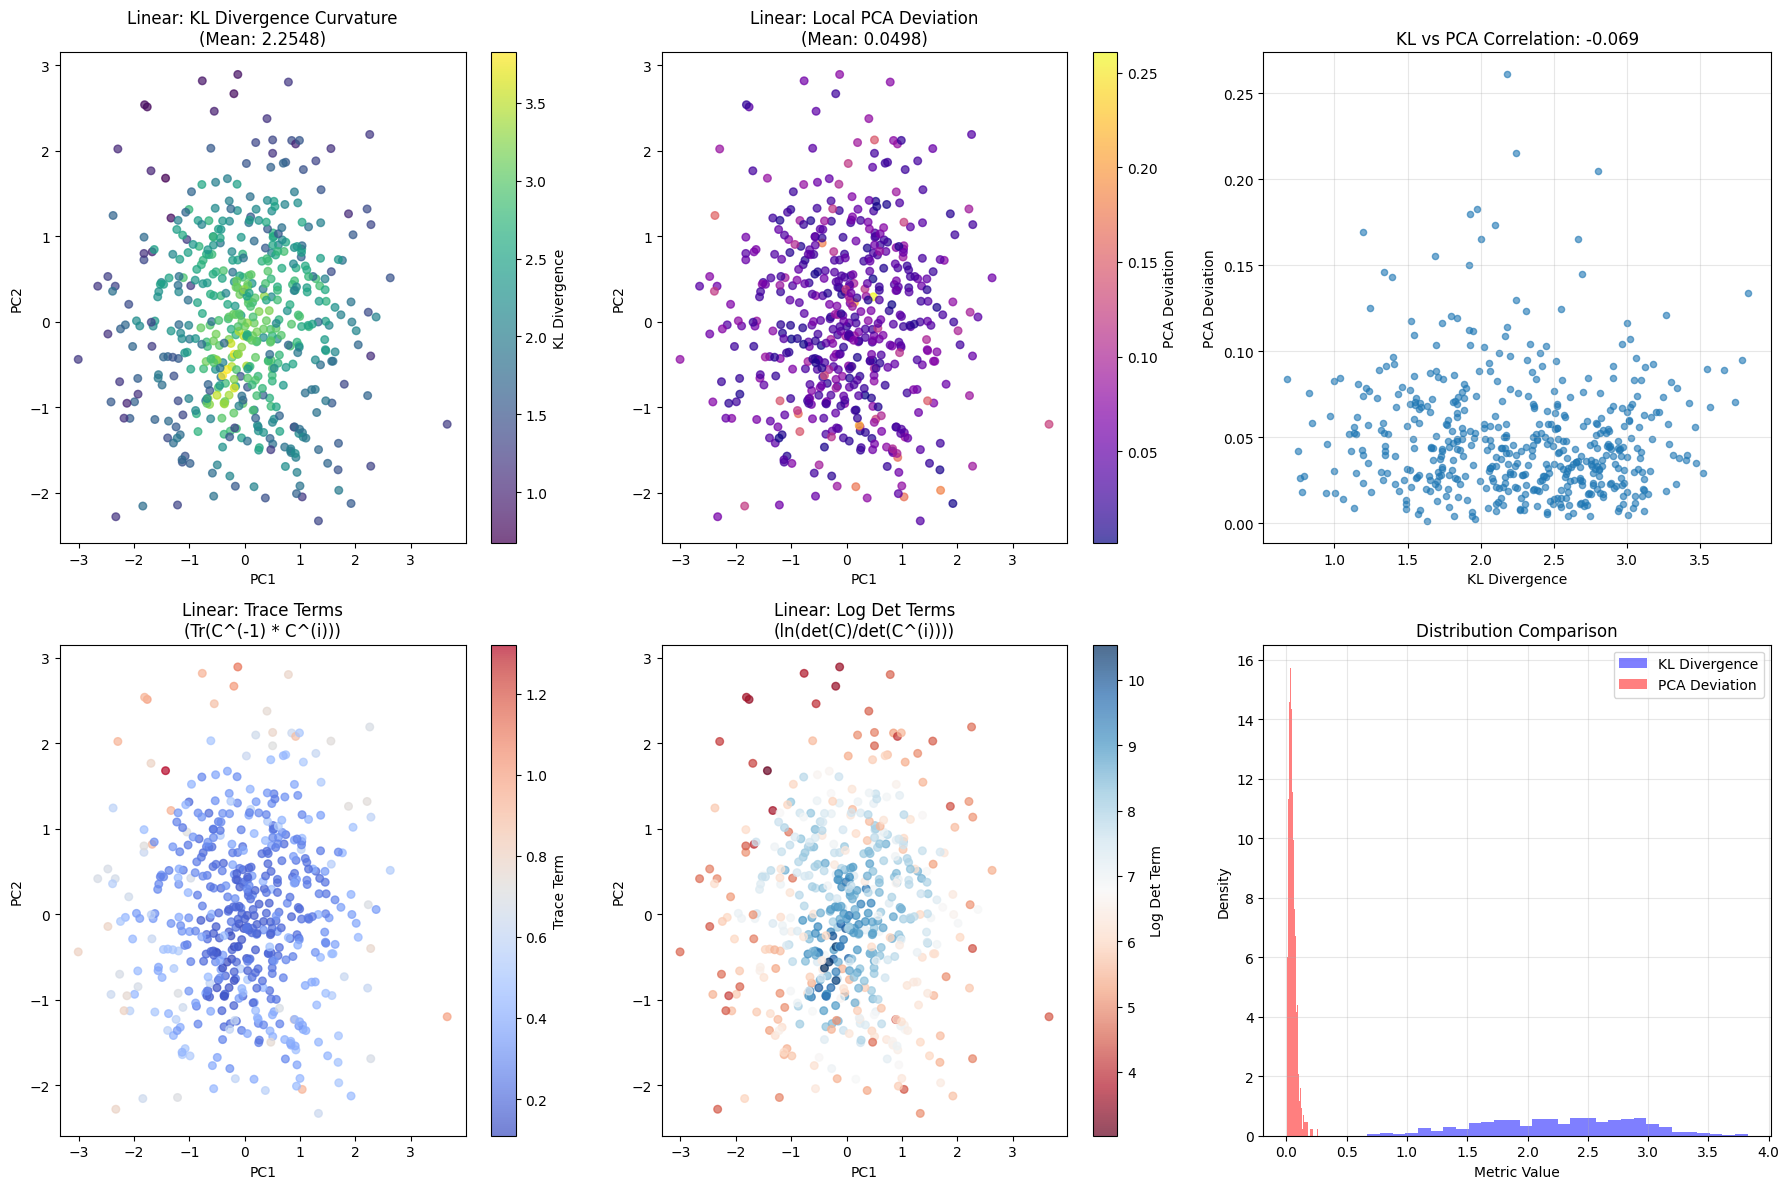


Analyzing: Swiss Roll

KL Divergence Analysis for Swiss Roll:
--------------------------------------------------
Mean KL Divergence: 4.202594
Std KL Divergence: 0.803127
Min KL Divergence: 1.586088
Max KL Divergence: 5.951222

Trace Term Statistics:
Mean Trace: 0.237220
Std Trace: 0.096504

Log Determinant Term Statistics:
Mean Log Det: 11.167967
Std Log Det: 1.686761

Global Determinant: 73900.238702
Local Determinants - Mean: 6.573584
Local Determinants - Std: 25.549545


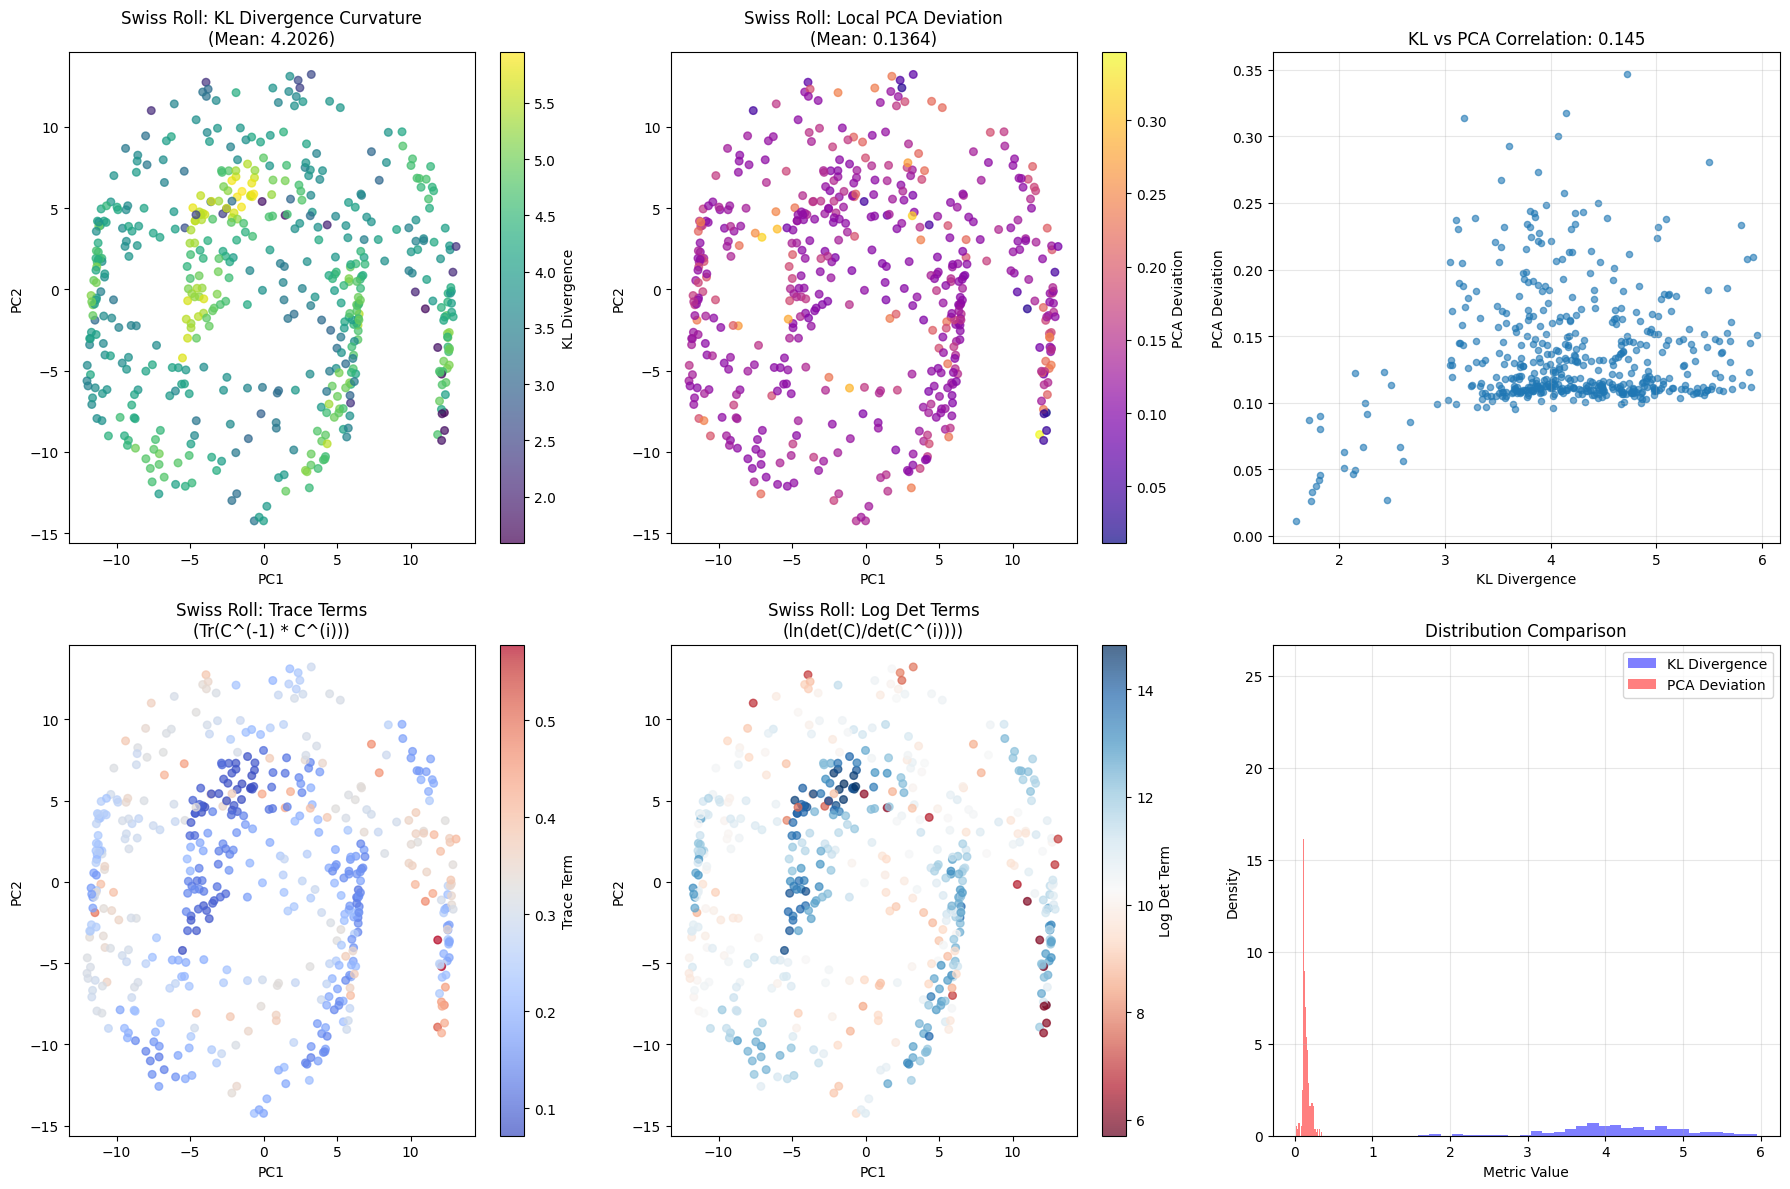


Analyzing: S-curve

KL Divergence Analysis for S-curve:
--------------------------------------------------
Mean KL Divergence: 3.675589
Std KL Divergence: 0.377034
Min KL Divergence: 2.554110
Max KL Divergence: 4.832160

Trace Term Statistics:
Mean Trace: 0.212795
Std Trace: 0.072913

Log Determinant Term Statistics:
Mean Log Det: 10.138384
Std Log Det: 0.807337

Global Determinant: 0.353124
Local Determinants - Mean: 0.000019
Local Determinants - Std: 0.000019


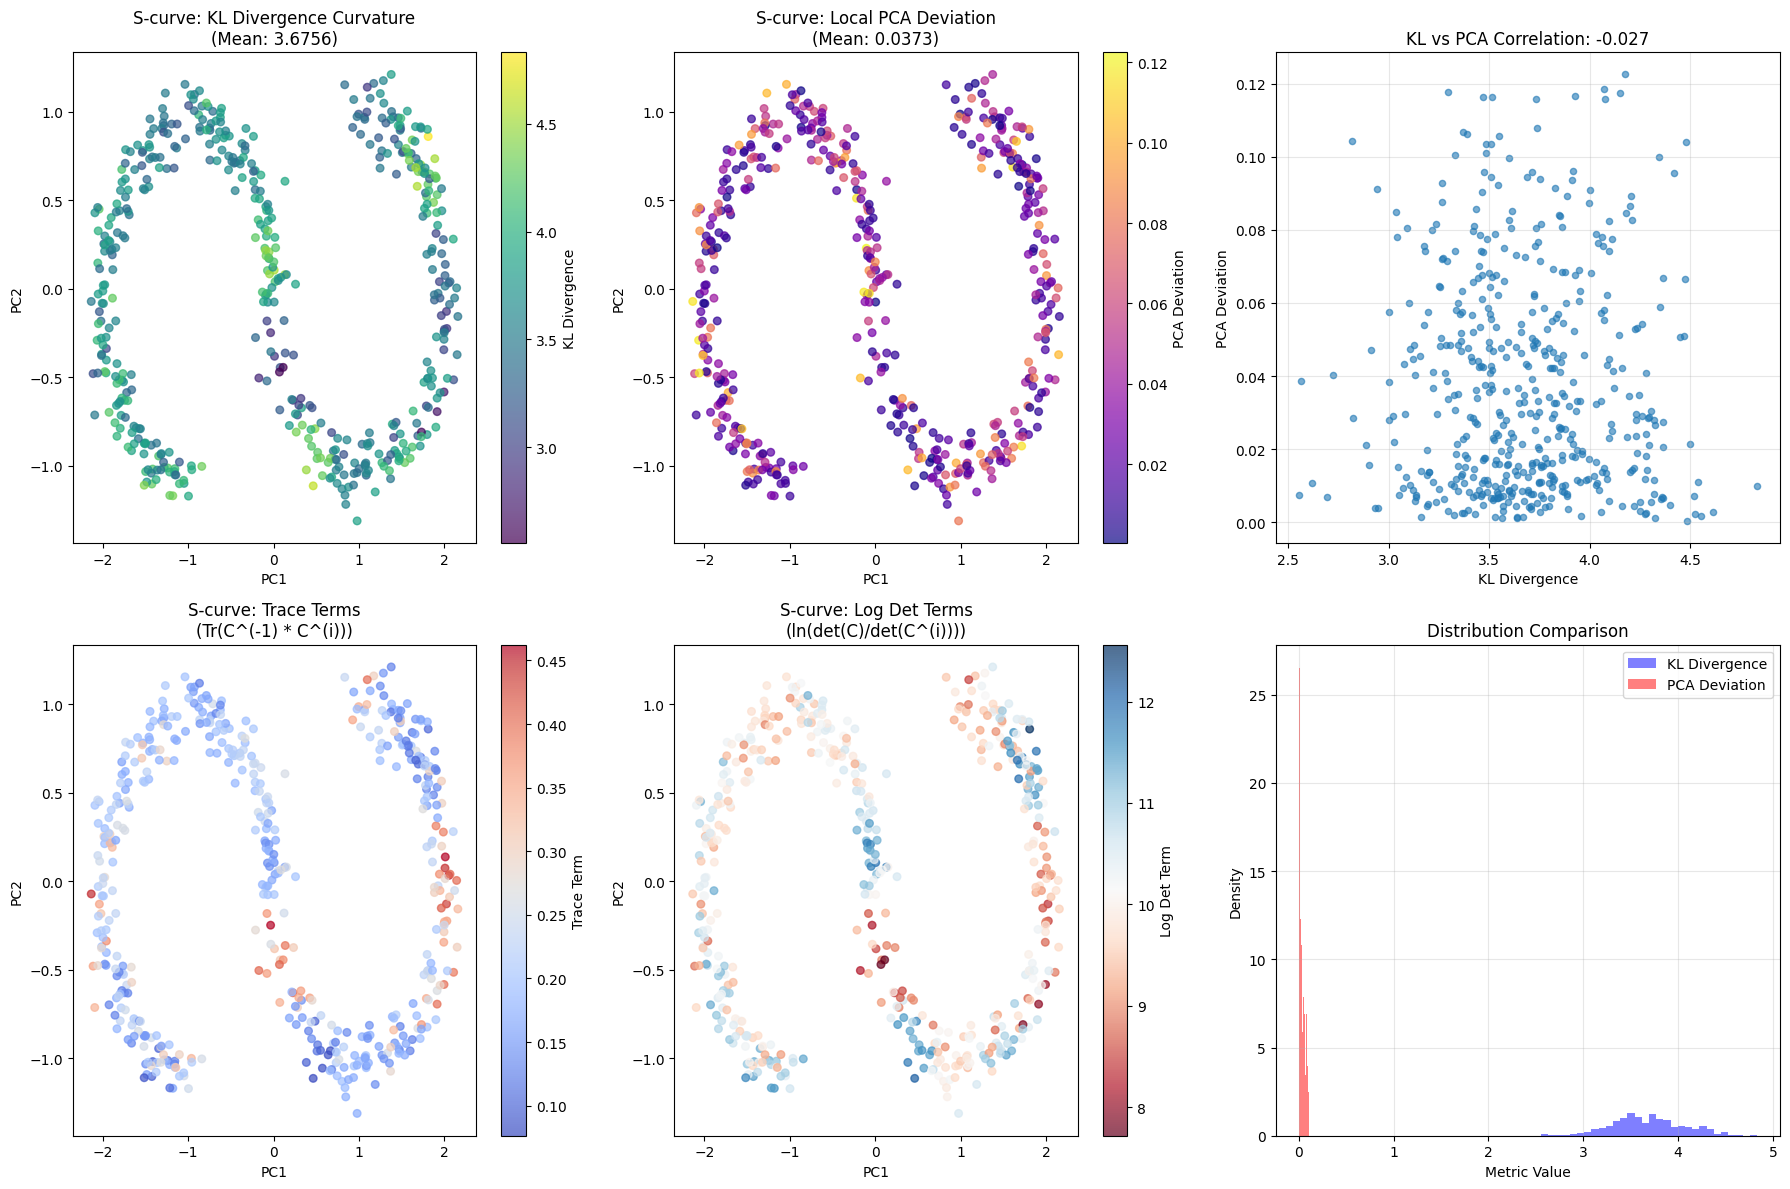


Analyzing: Circles

KL Divergence Analysis for Circles:
--------------------------------------------------
Mean KL Divergence: 2.743930
Std KL Divergence: 0.431265
Min KL Divergence: 1.843834
Max KL Divergence: 3.750848

Trace Term Statistics:
Mean Trace: 0.665002
Std Trace: 0.270936

Log Determinant Term Statistics:
Mean Log Det: 7.822858
Std Log Det: 1.027499

Global Determinant: 0.000987
Local Determinants - Mean: 0.000001
Local Determinants - Std: 0.000001


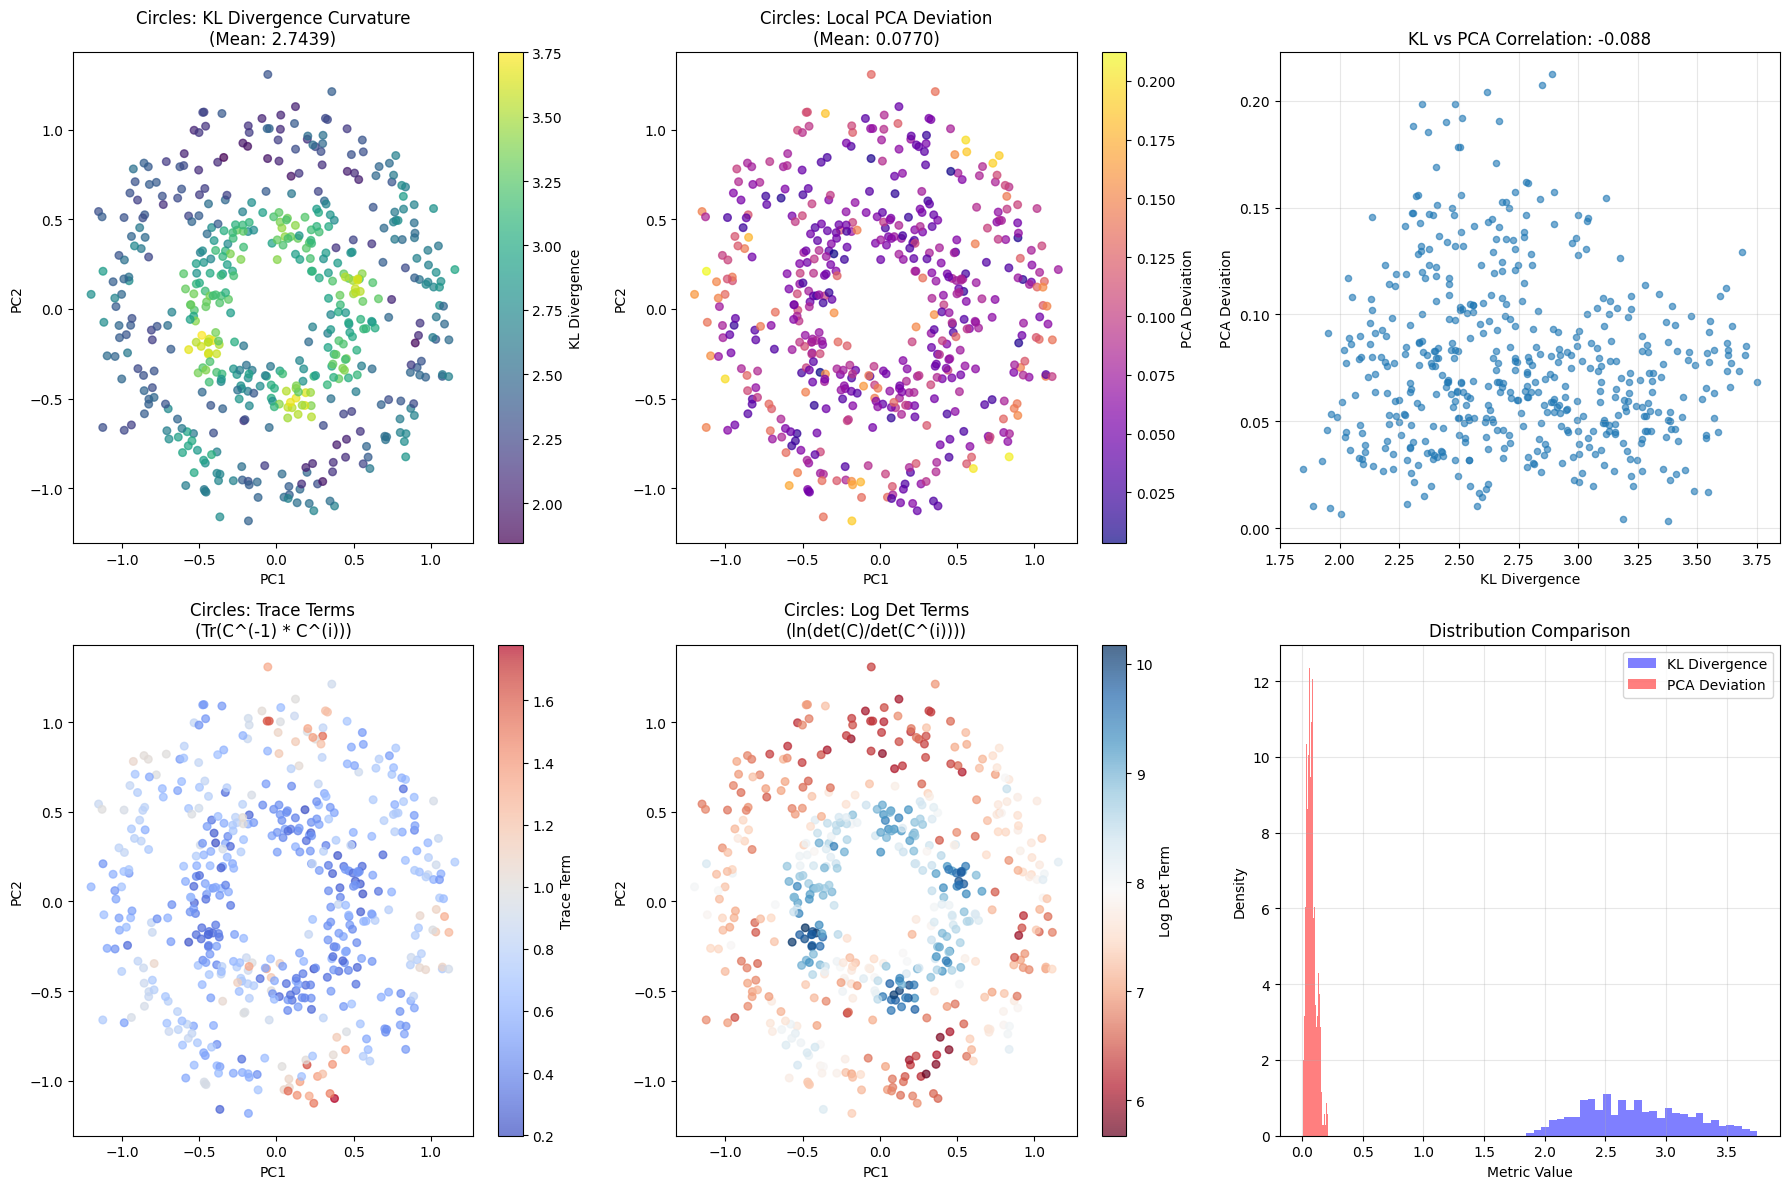


Analyzing: Moons

KL Divergence Analysis for Moons:
--------------------------------------------------
Mean KL Divergence: 3.326175
Std KL Divergence: 0.280910
Min KL Divergence: 2.362700
Max KL Divergence: 4.140794

Trace Term Statistics:
Mean Trace: 0.574135
Std Trace: 0.186186

Log Determinant Term Statistics:
Mean Log Det: 9.078214
Std Log Det: 0.651688

Global Determinant: 0.001476
Local Determinants - Mean: 0.000000
Local Determinants - Std: 0.000000


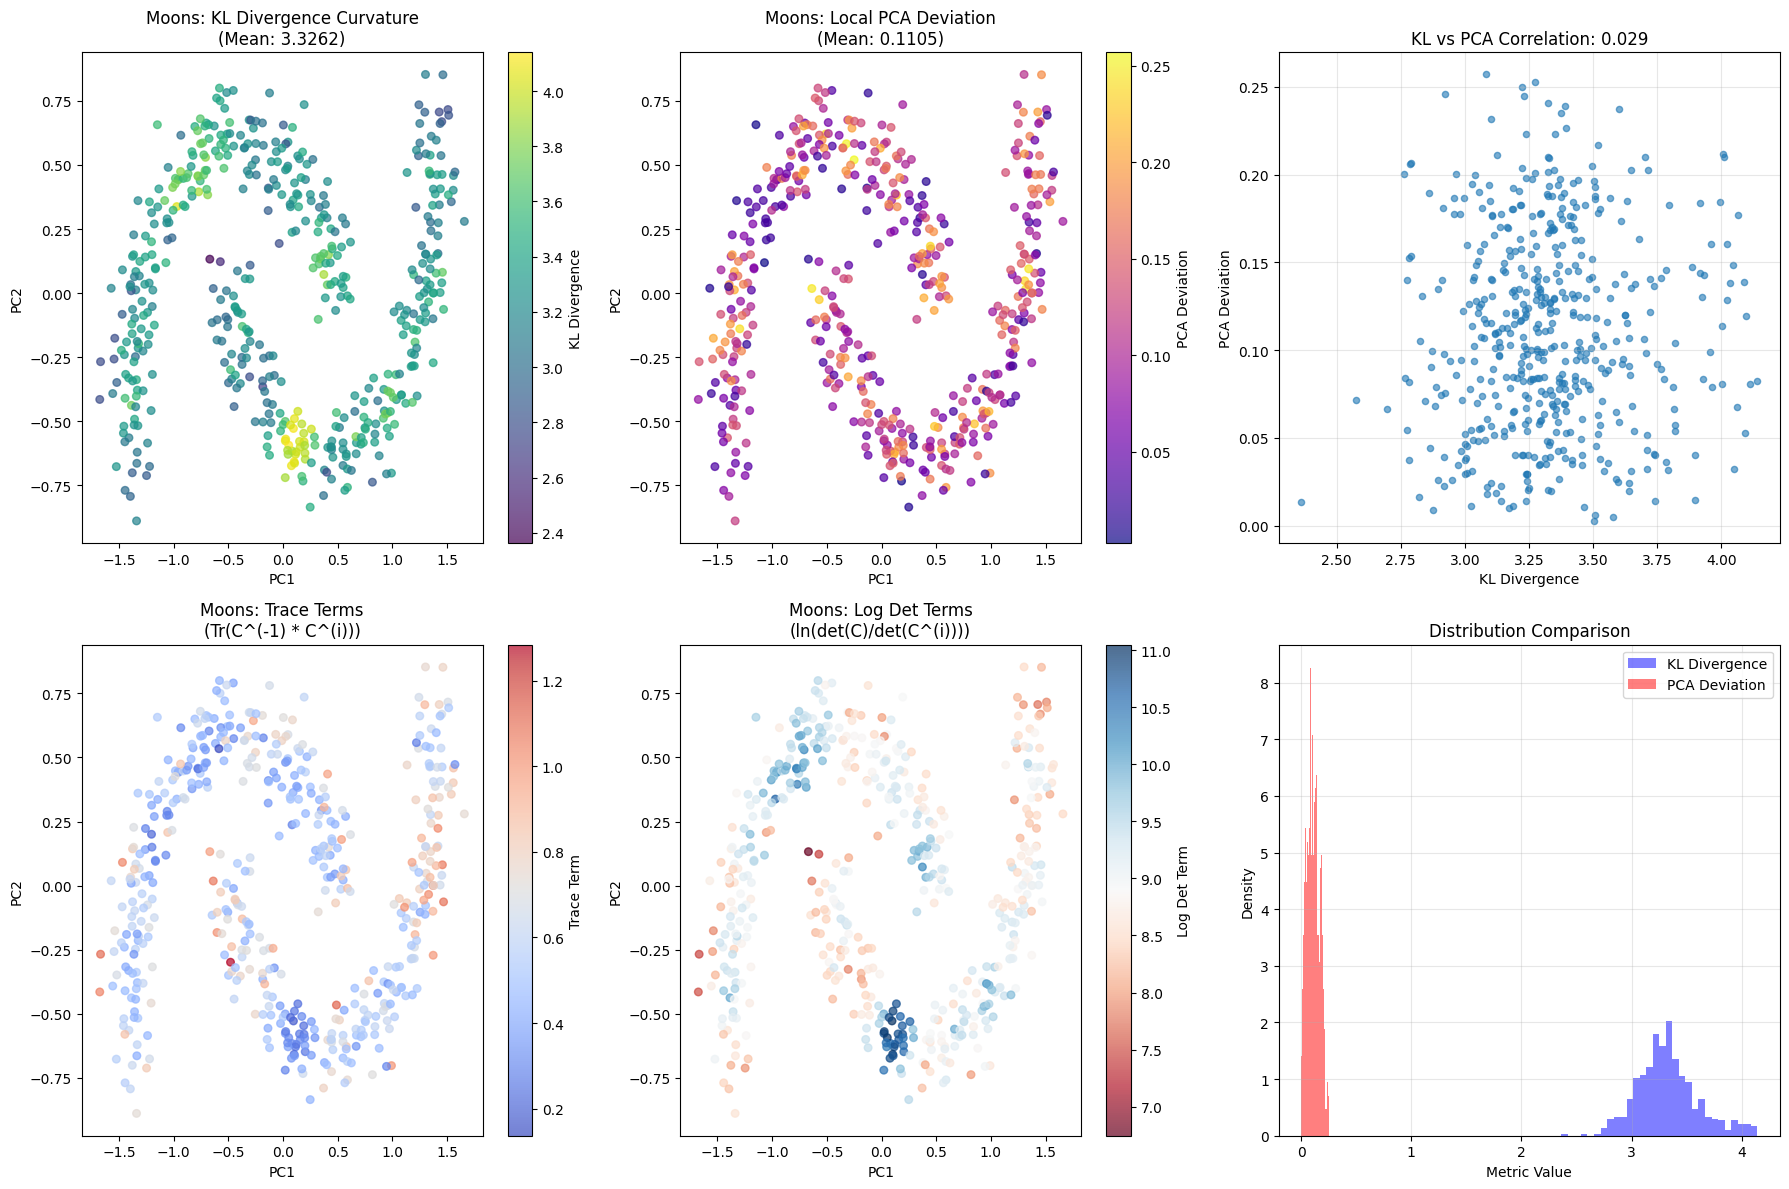


Analyzing: Helix

KL Divergence Analysis for Helix:
--------------------------------------------------
Mean KL Divergence: 4.648569
Std KL Divergence: 0.314498
Min KL Divergence: 3.907842
Max KL Divergence: 5.598969

Trace Term Statistics:
Mean Trace: 0.073450
Std Trace: 0.017102

Log Determinant Term Statistics:
Mean Log Det: 12.223688
Std Log Det: 0.642268

Global Determinant: 0.187416
Local Determinants - Mean: 0.000001
Local Determinants - Std: 0.000001


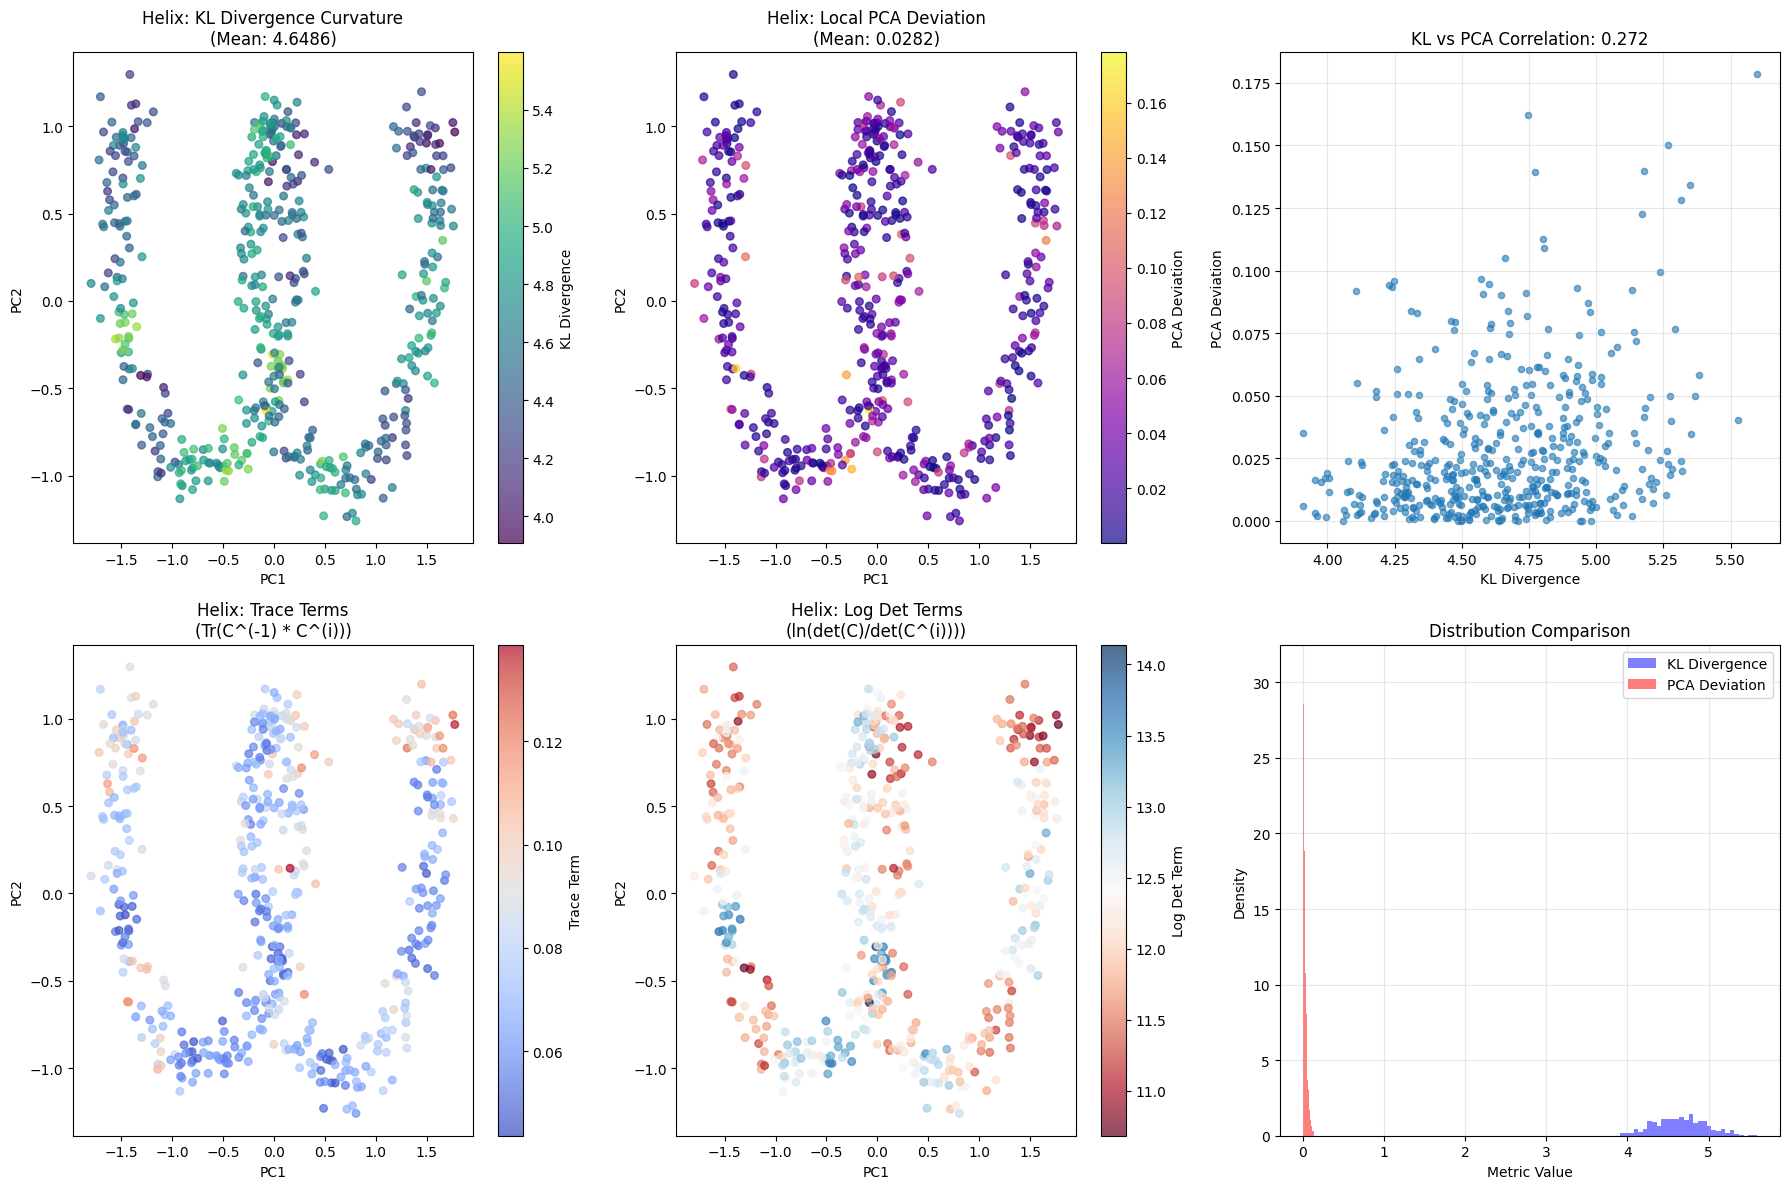


Analyzing: Sphere

KL Divergence Analysis for Sphere:
--------------------------------------------------
Mean KL Divergence: 3.221238
Std KL Divergence: 0.840348
Min KL Divergence: 1.563373
Max KL Divergence: 5.632990

Trace Term Statistics:
Mean Trace: 0.222048
Std Trace: 0.112171

Log Determinant Term Statistics:
Mean Log Det: 9.220428
Std Log Det: 1.782915

Global Determinant: 0.031742
Local Determinants - Mean: 0.000009
Local Determinants - Std: 0.000013


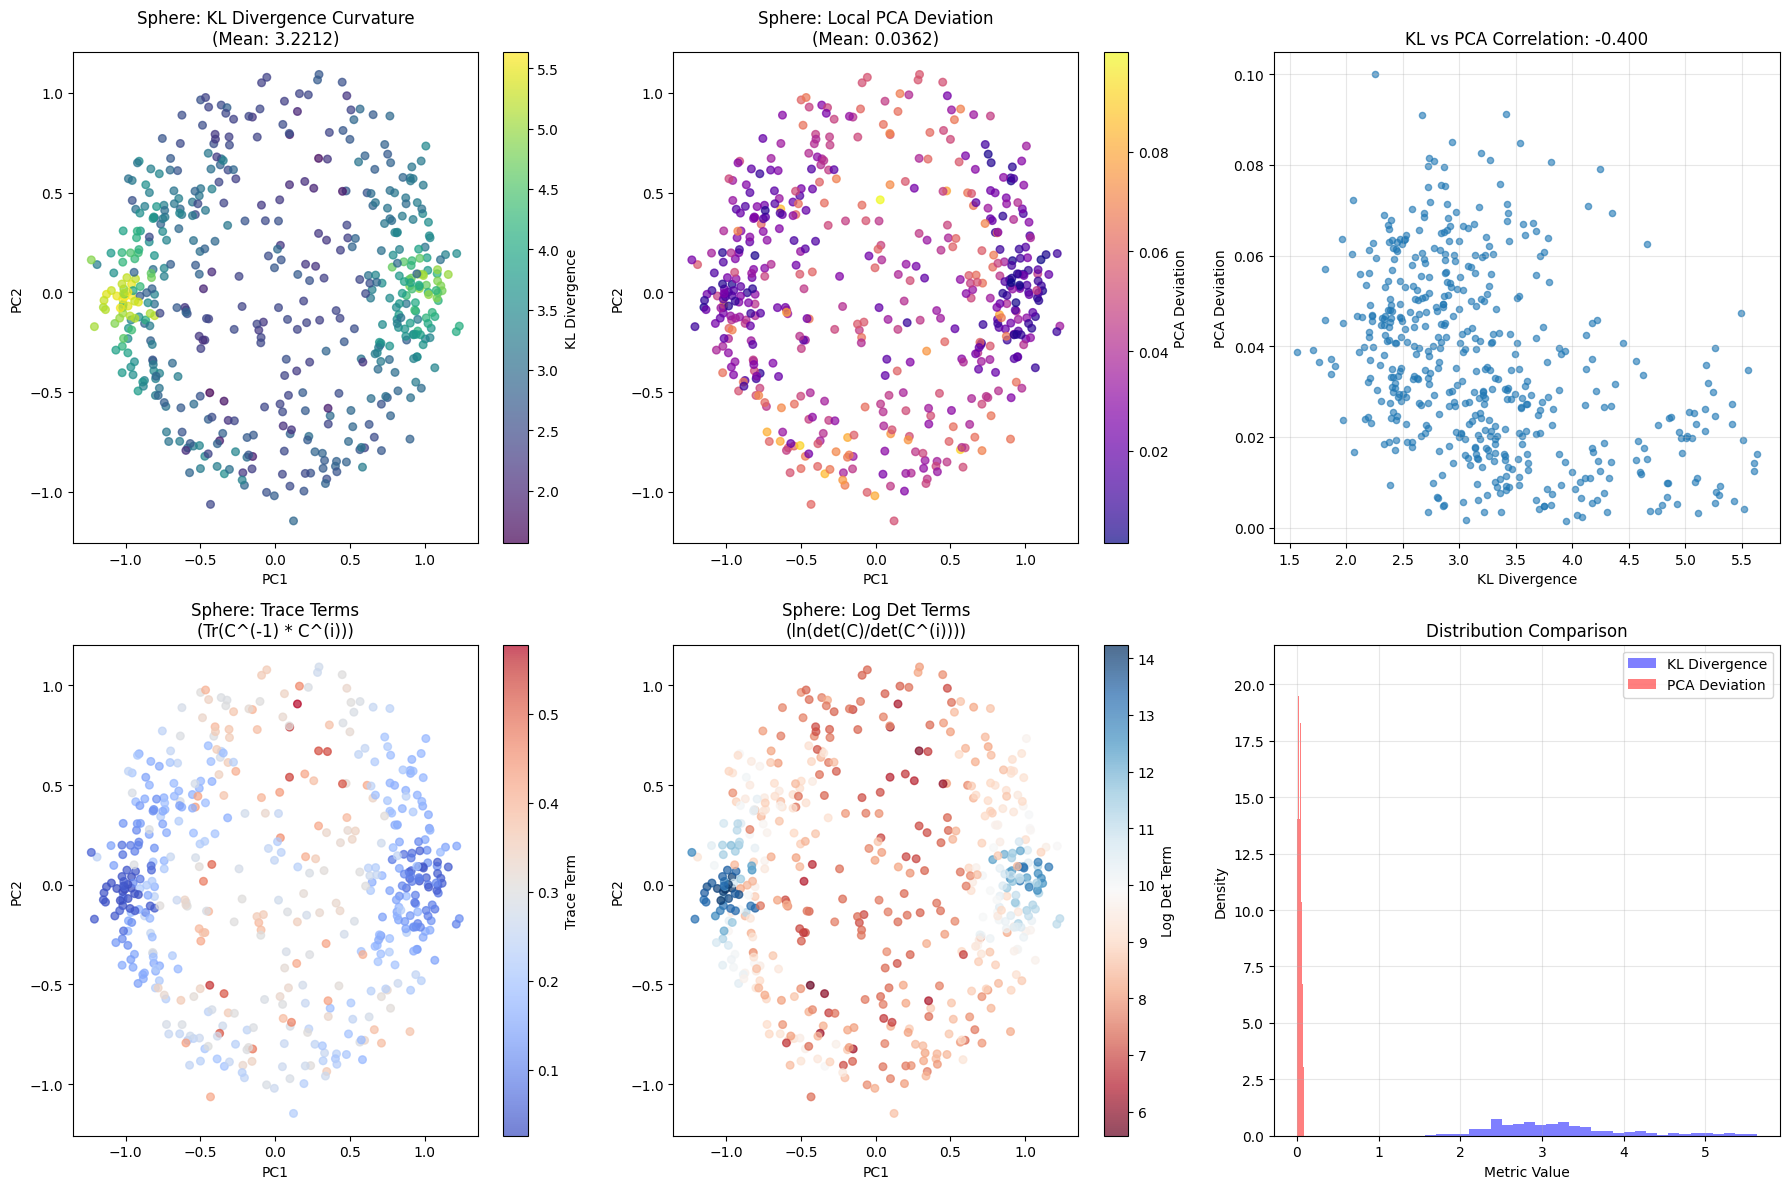


CORRELATION ANALYSIS
KL Divergence Curvature Correlations:
  vs Isomap Residual: 0.9099
  vs (1-Trustworthiness): -0.2761
  vs Combined Nonlinearity: 0.4371

Local PCA Deviation Correlations:
  vs Isomap Residual: 0.2184
  vs (1-Trustworthiness): 0.3756
  vs Combined Nonlinearity: 0.4981

Direct Comparison:
  KL vs PCA Deviation: 0.0693


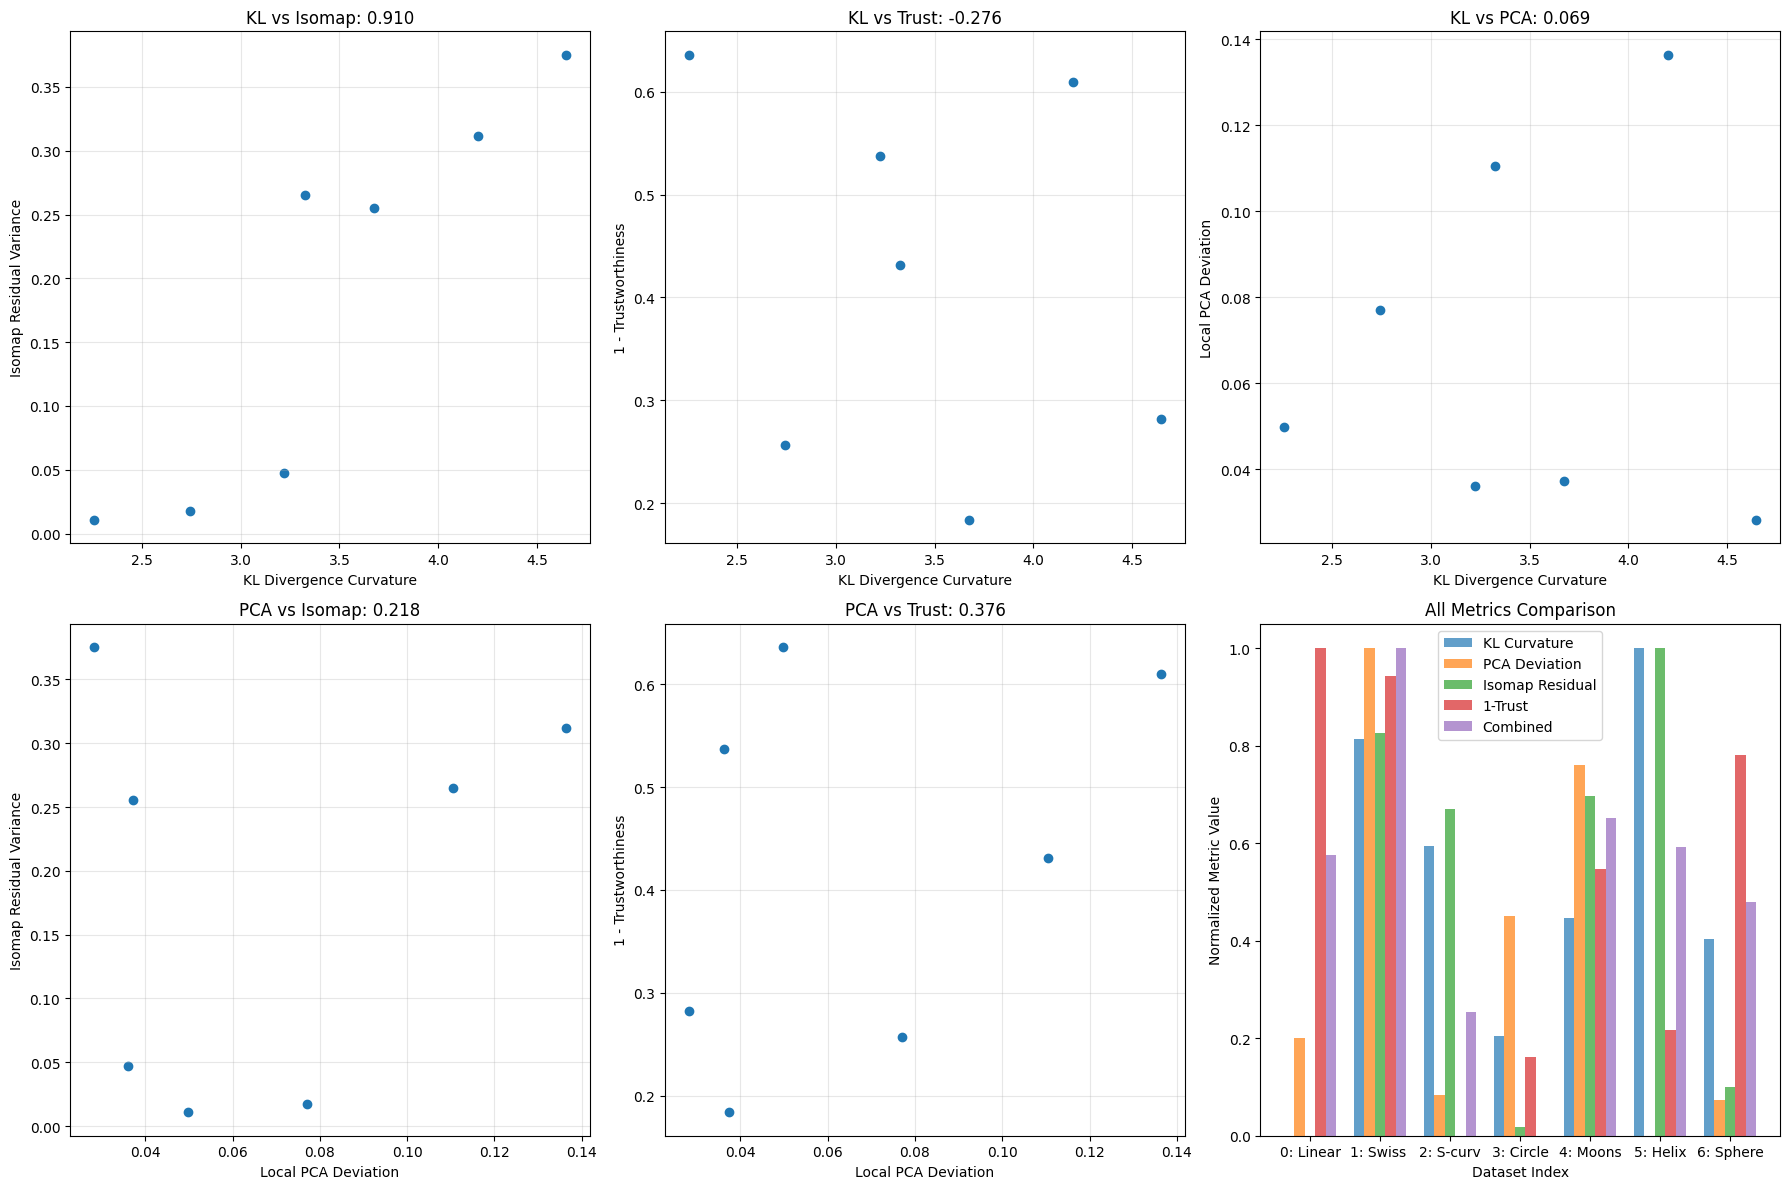


COMPREHENSIVE SUMMARY TABLE
----------------------------------------------------------------------------------------------------
Dataset      KL Curv    PCA Dev    Isomap   Trust  Cont   Combined  
----------------------------------------------------------------------------------------------------
Linear       2.25476    0.049801   0.01063  0.364  0.364  0.64683   
Swiss Roll   4.20259    0.136421   0.31174  0.390  0.390  0.92174   
S-curve      3.67559    0.037297   0.25520  0.816  0.816  0.43880   
Circles      2.74393    0.077010   0.01733  0.743  0.743  0.27413   
Moons        3.32617    0.110464   0.26496  0.569  0.569  0.69616   
Helix        4.64857    0.028179   0.37538  0.718  0.718  0.65718   
Sphere       3.22124    0.036161   0.04715  0.463  0.463  0.58455   


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_s_curve, make_circles, make_moons
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from scipy.linalg import pinv, det, logm
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import warnings
warnings.filterwarnings('ignore')

class NonlinearityAnalyzer:
    def __init__(self, k_neighbors=10, epsilon=1e-8, regularization=1e-6):
        """
        Initialize the nonlinearity analyzer
        
        Parameters:
        k_neighbors: number of nearest neighbors for local analysis
        epsilon: numerical stability parameter
        regularization: regularization parameter for matrix operations
        """
        self.k_neighbors = k_neighbors
        self.epsilon = epsilon
        self.regularization = regularization
        
    def compute_global_pca(self, X):
        """Compute global PCA statistics"""
        # Center the data
        X_centered = X - np.mean(X, axis=0)
        
        # Compute covariance matrix
        cov_global = np.cov(X_centered.T)
        
        # Add regularization for numerical stability
        cov_global += self.regularization * np.eye(cov_global.shape[0])
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_global)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_global
    
    def compute_local_pca(self, X, point_idx, neighbors_idx):
        """Compute local PCA for a specific point and its neighbors"""
        # Get local neighborhood
        X_local = X[neighbors_idx]
        
        # Center local data
        X_local_centered = X_local - np.mean(X_local, axis=0)
        
        # Compute local covariance
        if len(X_local) > 1:
            cov_local = np.cov(X_local_centered.T)
        else:
            # If only one point, create identity-like covariance
            cov_local = self.epsilon * np.eye(X.shape[1])
        
        # Add regularization for numerical stability
        cov_local += self.regularization * np.eye(cov_local.shape[0])
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_local)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_local
    
    def safe_matrix_inverse(self, matrix):
        """Safely compute matrix inverse with regularization"""
        try:
            # Try regular inverse first
            inv_matrix = np.linalg.inv(matrix)
            # Check if the inverse is reasonable
            if np.any(np.isnan(inv_matrix)) or np.any(np.isinf(inv_matrix)):
                raise np.linalg.LinAlgError("Invalid inverse")
            return inv_matrix
        except np.linalg.LinAlgError:
            # Use pseudo-inverse as fallback
            return pinv(matrix)
    
    def safe_determinant(self, matrix):
        """Safely compute determinant with numerical stability"""
        try:
            det_val = np.linalg.det(matrix)
            # Ensure determinant is positive and reasonable
            if det_val <= 0 or np.isnan(det_val) or np.isinf(det_val):
                # Use product of eigenvalues as determinant
                eigenvals = np.linalg.eigvals(matrix)
                det_val = np.prod(np.maximum(eigenvals, self.epsilon))
            return max(det_val, self.epsilon)
        except:
            return self.epsilon
    
    def kl_divergence_curvature(self, X):
        """
        Compute KL divergence-based curvature metric
        
        Formula: D_KL^(i) = 1/2 * [Tr(C^(-1) * C^(i)) - d + ln(det(C) / (det(C^(i)) + ε))]
        Overall metric: KLBasedCurvature = (1/n) * Σ_i D_KL^(i)
        """
        n_points, n_dims = X.shape
        
        # Find k-nearest neighbors for each point
        nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, n_points)).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Compute global covariance matrix
        global_eigenvals_norm, global_eigenvecs, global_cov = self.compute_global_pca(X)
        
        # Compute global covariance inverse
        global_cov_inv = self.safe_matrix_inverse(global_cov)
        global_det = self.safe_determinant(global_cov)
        
        # Compute KL divergences
        kl_divergences = []
        local_determinants = []
        trace_terms = []
        log_det_terms = []
        
        for i in range(n_points):
            # Get neighbors (excluding the point itself)
            neighbors_idx = indices[i][1:]  # Skip first element (the point itself)
            
            # Compute local covariance
            local_eigenvals_norm, local_eigenvecs, local_cov = self.compute_local_pca(X, i, neighbors_idx)
            
            # Compute local determinant
            local_det = self.safe_determinant(local_cov)
            local_determinants.append(local_det)
            
            # Compute trace term: Tr(C^(-1) * C^(i))
            trace_term = np.trace(global_cov_inv @ local_cov)
            trace_terms.append(trace_term)
            
            # Compute log determinant term: ln(det(C) / (det(C^(i)) + ε))
            log_det_term = np.log(global_det / (local_det + self.epsilon))
            log_det_terms.append(log_det_term)
            
            # Compute KL divergence
            kl_div = 0.5 * (trace_term - n_dims + log_det_term)
            kl_divergences.append(kl_div)
        
        # Average KL divergence across all points
        mean_kl_divergence = np.mean(kl_divergences)
        
        return {
            'mean_kl_divergence': mean_kl_divergence,
            'point_kl_divergences': np.array(kl_divergences),
            'trace_terms': np.array(trace_terms),
            'log_det_terms': np.array(log_det_terms),
            'local_determinants': np.array(local_determinants),
            'global_determinant': global_det,
            'global_cov': global_cov,
            'global_cov_inv': global_cov_inv,
            'neighbor_indices': indices
        }
    
    def local_pca_deviation(self, X):
        """
        Compute the Local PCA Deviation metric (from previous implementation)
        """
        n_points, n_dims = X.shape
        
        # Find k-nearest neighbors for each point
        nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, n_points)).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Compute global PCA
        global_eigenvals_norm, global_eigenvecs, global_cov = self.compute_global_pca(X)
        
        # Compute local deviations
        local_deviations = []
        local_eigenvals_all = []
        local_eigenvecs_all = []
        
        for i in range(n_points):
            # Get neighbors (excluding the point itself)
            neighbors_idx = indices[i][1:]  # Skip first element (the point itself)
            
            # Compute local PCA
            local_eigenvals_norm, local_eigenvecs, local_cov = self.compute_local_pca(X, i, neighbors_idx)
            
            # Compute squared differences between local and global normalized eigenvalues
            deviation = np.sum((local_eigenvals_norm - global_eigenvals_norm) ** 2)
            
            local_deviations.append(deviation)
            local_eigenvals_all.append(local_eigenvals_norm)
            local_eigenvecs_all.append(local_eigenvecs)
        
        # Average deviation across all points
        mean_deviation = np.mean(local_deviations)
        
        return {
            'mean_deviation': mean_deviation,
            'point_deviations': np.array(local_deviations),
            'global_eigenvals': global_eigenvals_norm,
            'global_eigenvecs': global_eigenvecs,
            'local_eigenvals': local_eigenvals_all,
            'local_eigenvecs': local_eigenvecs_all,
            'neighbor_indices': indices
        }
    
    def isomap_residual_variance(self, X, n_components=2):
        """Compute Isomap residual variance as reference nonlinearity metric"""
        # Compute Isomap embedding
        isomap = Isomap(n_components=n_components, n_neighbors=self.k_neighbors)
        X_embedded = isomap.fit_transform(X)
        
        # Get geodesic distance matrix
        geodesic_distances = isomap.dist_matrix_
        
        # Compute Euclidean distances in original space
        euclidean_distances = pairwise_distances(X)
        
        # Flatten distance matrices (only upper triangle to avoid duplicates)
        mask = np.triu(np.ones_like(geodesic_distances, dtype=bool), k=1)
        geo_flat = geodesic_distances[mask]
        euc_flat = euclidean_distances[mask]
        
        # Compute correlation coefficient
        correlation, _ = pearsonr(geo_flat, euc_flat)
        
        # Residual variance = 1 - R^2
        residual_variance = 1 - correlation**2
        
        return residual_variance, X_embedded, correlation
    
    def trustworthiness_continuity(self, X, X_embedded, k=10):
        """Compute trustworthiness and continuity metrics"""
        n_points = X.shape[0]
        
        # Compute k-nearest neighbors in original space
        nbrs_orig = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, indices_orig = nbrs_orig.kneighbors(X)
        
        # Compute k-nearest neighbors in embedded space
        nbrs_emb = NearestNeighbors(n_neighbors=k+1).fit(X_embedded)
        _, indices_emb = nbrs_emb.kneighbors(X_embedded)
        
        # Trustworthiness: are embedded neighbors true neighbors?
        trustworthiness = 0
        for i in range(n_points):
            orig_neighbors = set(indices_orig[i][1:])  # exclude point itself
            emb_neighbors = set(indices_emb[i][1:])
            
            # Count how many embedded neighbors are also original neighbors
            trustworthiness += len(orig_neighbors.intersection(emb_neighbors)) / k
        
        trustworthiness /= n_points
        
        # Continuity: are original neighbors preserved in embedding?
        continuity = 0
        for i in range(n_points):
            orig_neighbors = set(indices_orig[i][1:])
            emb_neighbors = set(indices_emb[i][1:])
            
            # Count how many original neighbors are also embedded neighbors
            continuity += len(orig_neighbors.intersection(emb_neighbors)) / k
        
        continuity /= n_points
        
        return trustworthiness, continuity

def generate_test_datasets():
    """Generate various test datasets with different nonlinearity characteristics"""
    datasets = {}
    
    # 1. Linear data (should have low nonlinearity)
    np.random.seed(42)
    linear_data = np.random.randn(500, 3)
    datasets['Linear'] = linear_data
    
    # 2. Swiss Roll (high nonlinearity)
    swiss_roll, color = make_swiss_roll(n_samples=500, noise=0.1, random_state=42)
    datasets['Swiss Roll'] = swiss_roll
    
    # 3. S-curve (medium nonlinearity)
    s_curve, color = make_s_curve(n_samples=500, noise=0.1, random_state=42)
    datasets['S-curve'] = s_curve
    
    # 4. Circles (2D nonlinear)
    circles, _ = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
    # Embed in 3D
    circles_3d = np.column_stack([circles, np.random.randn(500) * 0.1])
    datasets['Circles'] = circles_3d
    
    # 5. Moons (2D nonlinear)
    moons, _ = make_moons(n_samples=500, noise=0.1, random_state=42)
    # Embed in 3D
    moons_3d = np.column_stack([moons, np.random.randn(500) * 0.1])
    datasets['Moons'] = moons_3d
    
    # 6. Helix (highly nonlinear)
    t = np.linspace(0, 4*np.pi, 500)
    helix = np.column_stack([
        np.cos(t) + 0.1*np.random.randn(500),
        np.sin(t) + 0.1*np.random.randn(500),
        t/4 + 0.1*np.random.randn(500)
    ])
    datasets['Helix'] = helix
    
    # 7. Sphere (curved but regular)
    phi = np.random.uniform(0, 2*np.pi, 500)
    theta = np.random.uniform(0, np.pi, 500)
    radius = 1 + 0.1*np.random.randn(500)
    sphere = np.column_stack([
        radius * np.sin(theta) * np.cos(phi),
        radius * np.sin(theta) * np.sin(phi),
        radius * np.cos(theta)
    ])
    datasets['Sphere'] = sphere
    
    return datasets

def visualize_kl_curvature_2d(X, kl_results, pca_results, dataset_name, n_arrows=20):
    """
    Create comprehensive 2D visualization for KL divergence-based curvature
    """
    # Project to 2D using PCA for visualization
    pca_2d = PCA(n_components=2)
    X_2d = pca_2d.fit_transform(X)
    
    # Create the plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Data colored by KL divergence
    scatter1 = axes[0,0].scatter(X_2d[:, 0], X_2d[:, 1], 
                                c=kl_results['point_kl_divergences'], 
                                cmap='viridis', s=30, alpha=0.7)
    axes[0,0].set_title(f'{dataset_name}: KL Divergence Curvature\n(Mean: {kl_results["mean_kl_divergence"]:.4f})')
    axes[0,0].set_xlabel('PC1')
    axes[0,0].set_ylabel('PC2')
    plt.colorbar(scatter1, ax=axes[0,0], label='KL Divergence')
    
    # Plot 2: Data colored by Local PCA deviation
    scatter2 = axes[0,1].scatter(X_2d[:, 0], X_2d[:, 1], 
                                c=pca_results['point_deviations'], 
                                cmap='plasma', s=30, alpha=0.7)
    axes[0,1].set_title(f'{dataset_name}: Local PCA Deviation\n(Mean: {pca_results["mean_deviation"]:.4f})')
    axes[0,1].set_xlabel('PC1')
    axes[0,1].set_ylabel('PC2')
    plt.colorbar(scatter2, ax=axes[0,1], label='PCA Deviation')
    
    # Plot 3: Correlation between KL and PCA metrics
    correlation_kl_pca = pearsonr(kl_results['point_kl_divergences'], 
                                 pca_results['point_deviations'])[0]
    axes[0,2].scatter(kl_results['point_kl_divergences'], 
                     pca_results['point_deviations'], 
                     alpha=0.6, s=20)
    axes[0,2].set_xlabel('KL Divergence')
    axes[0,2].set_ylabel('PCA Deviation')
    axes[0,2].set_title(f'KL vs PCA Correlation: {correlation_kl_pca:.3f}')
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Trace terms visualization
    scatter4 = axes[1,0].scatter(X_2d[:, 0], X_2d[:, 1], 
                                c=kl_results['trace_terms'], 
                                cmap='coolwarm', s=30, alpha=0.7)
    axes[1,0].set_title(f'{dataset_name}: Trace Terms\n(Tr(C^(-1) * C^(i)))')
    axes[1,0].set_xlabel('PC1')
    axes[1,0].set_ylabel('PC2')
    plt.colorbar(scatter4, ax=axes[1,0], label='Trace Term')
    
    # Plot 5: Log determinant terms visualization
    scatter5 = axes[1,1].scatter(X_2d[:, 0], X_2d[:, 1], 
                                c=kl_results['log_det_terms'], 
                                cmap='RdBu', s=30, alpha=0.7)
    axes[1,1].set_title(f'{dataset_name}: Log Det Terms\n(ln(det(C)/det(C^(i))))')
    axes[1,1].set_xlabel('PC1')
    axes[1,1].set_ylabel('PC2')
    plt.colorbar(scatter5, ax=axes[1,1], label='Log Det Term')
    
    # Plot 6: Histogram comparison of both metrics
    axes[1,2].hist(kl_results['point_kl_divergences'], bins=30, alpha=0.5, 
                  label='KL Divergence', density=True, color='blue')
    axes[1,2].hist(pca_results['point_deviations'], bins=30, alpha=0.5, 
                  label='PCA Deviation', density=True, color='red')
    axes[1,2].set_xlabel('Metric Value')
    axes[1,2].set_ylabel('Density')
    axes[1,2].set_title('Distribution Comparison')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def analyze_kl_components(kl_results, dataset_name):
    """Analyze the components of KL divergence metric"""
    print(f"\nKL Divergence Analysis for {dataset_name}:")
    print("-" * 50)
    print(f"Mean KL Divergence: {kl_results['mean_kl_divergence']:.6f}")
    print(f"Std KL Divergence: {np.std(kl_results['point_kl_divergences']):.6f}")
    print(f"Min KL Divergence: {np.min(kl_results['point_kl_divergences']):.6f}")
    print(f"Max KL Divergence: {np.max(kl_results['point_kl_divergences']):.6f}")
    
    print(f"\nTrace Term Statistics:")
    print(f"Mean Trace: {np.mean(kl_results['trace_terms']):.6f}")
    print(f"Std Trace: {np.std(kl_results['trace_terms']):.6f}")
    
    print(f"\nLog Determinant Term Statistics:")
    print(f"Mean Log Det: {np.mean(kl_results['log_det_terms']):.6f}")
    print(f"Std Log Det: {np.std(kl_results['log_det_terms']):.6f}")
    
    print(f"\nGlobal Determinant: {kl_results['global_determinant']:.6f}")
    print(f"Local Determinants - Mean: {np.mean(kl_results['local_determinants']):.6f}")
    print(f"Local Determinants - Std: {np.std(kl_results['local_determinants']):.6f}")

def run_comprehensive_kl_analysis():
    """Run comprehensive analysis with both KL divergence and Local PCA metrics"""
    
    # Generate datasets
    datasets = generate_test_datasets()
    
    # Initialize analyzer
    analyzer = NonlinearityAnalyzer(k_neighbors=15, regularization=1e-6)
    
    # Store results
    results_summary = []
    
    print("Comprehensive Nonlinearity Analysis")
    print("KL Divergence vs Local PCA Deviation")
    print("=" * 60)
    
    for name, data in datasets.items():
        print(f"\nAnalyzing: {name}")
        print("=" * 40)
        
        # Compute KL Divergence-based curvature
        kl_results = analyzer.kl_divergence_curvature(data)
        
        # Compute Local PCA Deviation
        pca_results = analyzer.local_pca_deviation(data)
        
        # Compute reference metrics
        isomap_residual, data_embedded, correlation = analyzer.isomap_residual_variance(data)
        trustworthiness, continuity = analyzer.trustworthiness_continuity(data, data_embedded)
        
        # Analyze KL components
        analyze_kl_components(kl_results, name)
        
        # Store results
        result = {
            'dataset': name,
            'kl_divergence_curvature': kl_results['mean_kl_divergence'],
            'local_pca_deviation': pca_results['mean_deviation'],
            'isomap_residual_variance': isomap_residual,
            'geodesic_euclidean_correlation': correlation,
            'trustworthiness': trustworthiness,
            'continuity': continuity,
            'nonlinearity_score': (1 - trustworthiness) + isomap_residual  # Combined reference
        }
        results_summary.append(result)
        
        # Create visualizations
        if data.shape[1] >= 2:
            fig = visualize_kl_curvature_2d(data, kl_results, pca_results, name)
            plt.show()
    
    # Convert to pandas DataFrame for analysis
    import pandas as pd
    df = pd.DataFrame(results_summary)
    
    # Comprehensive correlation analysis
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)
    
    # Correlations with reference metrics
    corr_kl_isomap = pearsonr(df['kl_divergence_curvature'], df['isomap_residual_variance'])[0]
    corr_kl_trust = pearsonr(df['kl_divergence_curvature'], 1 - df['trustworthiness'])[0]
    corr_kl_combined = pearsonr(df['kl_divergence_curvature'], df['nonlinearity_score'])[0]
    
    corr_pca_isomap = pearsonr(df['local_pca_deviation'], df['isomap_residual_variance'])[0]
    corr_pca_trust = pearsonr(df['local_pca_deviation'], 1 - df['trustworthiness'])[0]
    corr_pca_combined = pearsonr(df['local_pca_deviation'], df['nonlinearity_score'])[0]
    
    # Direct comparison between KL and PCA
    corr_kl_pca = pearsonr(df['kl_divergence_curvature'], df['local_pca_deviation'])[0]
    
    print(f"KL Divergence Curvature Correlations:")
    print(f"  vs Isomap Residual: {corr_kl_isomap:.4f}")
    print(f"  vs (1-Trustworthiness): {corr_kl_trust:.4f}")
    print(f"  vs Combined Nonlinearity: {corr_kl_combined:.4f}")
    
    print(f"\nLocal PCA Deviation Correlations:")
    print(f"  vs Isomap Residual: {corr_pca_isomap:.4f}")
    print(f"  vs (1-Trustworthiness): {corr_pca_trust:.4f}")
    print(f"  vs Combined Nonlinearity: {corr_pca_combined:.4f}")
    
    print(f"\nDirect Comparison:")
    print(f"  KL vs PCA Deviation: {corr_kl_pca:.4f}")
    
    # Create comprehensive correlation visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # KL vs reference metrics
    axes[0,0].scatter(df['kl_divergence_curvature'], df['isomap_residual_variance'])
    axes[0,0].set_xlabel('KL Divergence Curvature')
    axes[0,0].set_ylabel('Isomap Residual Variance')
    axes[0,0].set_title(f'KL vs Isomap: {corr_kl_isomap:.3f}')
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].scatter(df['kl_divergence_curvature'], 1 - df['trustworthiness'])
    axes[0,1].set_xlabel('KL Divergence Curvature')
    axes[0,1].set_ylabel('1 - Trustworthiness')
    axes[0,1].set_title(f'KL vs Trust: {corr_kl_trust:.3f}')
    axes[0,1].grid(True, alpha=0.3)
    
    axes[0,2].scatter(df['kl_divergence_curvature'], df['local_pca_deviation'])
    axes[0,2].set_xlabel('KL Divergence Curvature')
    axes[0,2].set_ylabel('Local PCA Deviation')
    axes[0,2].set_title(f'KL vs PCA: {corr_kl_pca:.3f}')
    axes[0,2].grid(True, alpha=0.3)
    
    # PCA vs reference metrics
    axes[1,0].scatter(df['local_pca_deviation'], df['isomap_residual_variance'])
    axes[1,0].set_xlabel('Local PCA Deviation')
    axes[1,0].set_ylabel('Isomap Residual Variance')
    axes[1,0].set_title(f'PCA vs Isomap: {corr_pca_isomap:.3f}')
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].scatter(df['local_pca_deviation'], 1 - df['trustworthiness'])
    axes[1,1].set_xlabel('Local PCA Deviation')
    axes[1,1].set_ylabel('1 - Trustworthiness')
    axes[1,1].set_title(f'PCA vs Trust: {corr_pca_trust:.3f}')
    axes[1,1].grid(True, alpha=0.3)
    
    # Comparison summary
    metrics = ['KL Curvature', 'PCA Deviation', 'Isomap Residual', '1-Trust', 'Combined']
    values = [df['kl_divergence_curvature'], df['local_pca_deviation'], 
              df['isomap_residual_variance'], 1-df['trustworthiness'], df['nonlinearity_score']]
    
    # Normalize values for comparison
    normalized_values = []
    for val in values:
        normalized_values.append((val - val.min()) / (val.max() - val.min()))
    
    x = np.arange(len(df))
    width = 0.15
    for i, (metric, norm_val) in enumerate(zip(metrics, normalized_values)):
        axes[1,2].bar(x + i*width, norm_val, width, label=metric, alpha=0.7)
    
    axes[1,2].set_xlabel('Dataset Index')
    axes[1,2].set_ylabel('Normalized Metric Value')
    axes[1,2].set_title('All Metrics Comparison')
    axes[1,2].legend()
    axes[1,2].set_xticks(x + width * 2)
    axes[1,2].set_xticklabels([f"{i}: {name[:6]}" for i, name in enumerate(df['dataset'])])
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary table
    print("\nCOMPREHENSIVE SUMMARY TABLE")
    print("-" * 100)
    print(f"{'Dataset':<12} {'KL Curv':<10} {'PCA Dev':<10} {'Isomap':<8} {'Trust':<6} {'Cont':<6} {'Combined':<10}")
    print("-" * 100)
    for _, row in df.iterrows():
        print(f"{row['dataset']:<12} {row['kl_divergence_curvature']:<10.5f} "
              f"{row['local_pca_deviation']:<10.6f} {row['isomap_residual_variance']:<8.5f} "
              f"{row['trustworthiness']:<6.3f} {row['continuity']:<6.3f} "
              f"{row['nonlinearity_score']:<10.5f}")
    
    return df, results_summary

def analyze_custom_dataset_kl(X, dataset_name="Custom", k_neighbors=15, visualize=True):
    """
    Analyze a custom dataset with both KL divergence and Local PCA metrics
    
    Parameters:
    X: numpy array of shape (n_samples, n_features)
    dataset_name: string name for the dataset
    k_neighbors: number of neighbors for local analysis
    visualize: whether to create visualizations
    """
    analyzer = NonlinearityAnalyzer(k_neighbors=k_neighbors, regularization=1e-6)
    
    # Compute both metrics
    kl_results = analyzer.kl_divergence_curvature(X)
    pca_results = analyzer.local_pca_deviation(X)
    isomap_residual, X_embedded, correlation = analyzer.isomap_residual_variance(X)
    trustworthiness, continuity = analyzer.trustworthiness_continuity(X, X_embedded)
    
    print(f"Analysis Results for {dataset_name}:")
    print("-" * 50)
    print(f"KL Divergence Curvature: {kl_results['mean_kl_divergence']:.6f}")
    print(f"Local PCA Deviation: {pca_results['mean_deviation']:.6f}")
    print(f"Isomap Residual Variance: {isomap_residual:.6f}")
    print(f"Trustworthiness: {trustworthiness:.6f}")
    print(f"Continuity: {continuity:.6f}")
    
    # Analyze KL components
    analyze_kl_components(kl_results, dataset_name)
    
    if visualize and X.shape[1] >= 2:
        fig = visualize_kl_curvature_2d(X, kl_results, pca_results, dataset_name)
        plt.show()
    
    return {
        'kl_divergence_curvature': kl_results['mean_kl_divergence'],
        'local_pca_deviation': pca_results['mean_deviation'],
        'isomap_residual_variance': isomap_residual,
        'trustworthiness': trustworthiness,
        'continuity': continuity,
        'detailed_kl_results': kl_results,
        'detailed_pca_results': pca_results
    }

# Example usage:
if __name__ == "__main__":
    # Run comprehensive analysis with both metrics
    df, detailed_results = run_comprehensive_kl_analysis()
    
    # Example of analyzing a custom dataset
    # np.random.seed(42)
    # custom_data = np.random.randn(200, 3)  # Replace with your data
    # custom_results = analyze_custom_dataset_kl(custom_data, "My Dataset")

COMPREHENSIVE KL DIVERGENCE CURVATURE EXPLORATION
Generating comprehensive dataset collection...
Generated 36 datasets for analysis

Analyzing datasets...
----------------------------------------
[ 1/36] Processing: Linear_3D                 ✓ KL=2.0830
[ 2/36] Processing: Linear_Correlated         ✓ KL=2.6072
[ 3/36] Processing: Linear_5D                 ✓ KL=2.1035
[ 4/36] Processing: Linear_LowNoise           ✓ KL=0.5863
[ 5/36] Processing: Linear_HighNoise          ✓ KL=2.0415
[ 6/36] Processing: Swiss_Roll                ✓ KL=3.6367
[ 7/36] Processing: Swiss_Roll_Noisy          ✓ KL=3.3588
[ 8/36] Processing: S_Curve                   ✓ KL=3.3646
[ 9/36] Processing: S_Curve_Noisy             ✓ KL=2.4461
[10/36] Processing: Circles                   ✓ KL=2.6047
[11/36] Processing: Moons                     ✓ KL=3.1656
[12/36] Processing: Multiple_Rings            ✓ KL=4.5088
[13/36] Processing: Helix                     ✓ KL=4.5814
[14/36] Processing: Double_Helix              ✓ KL

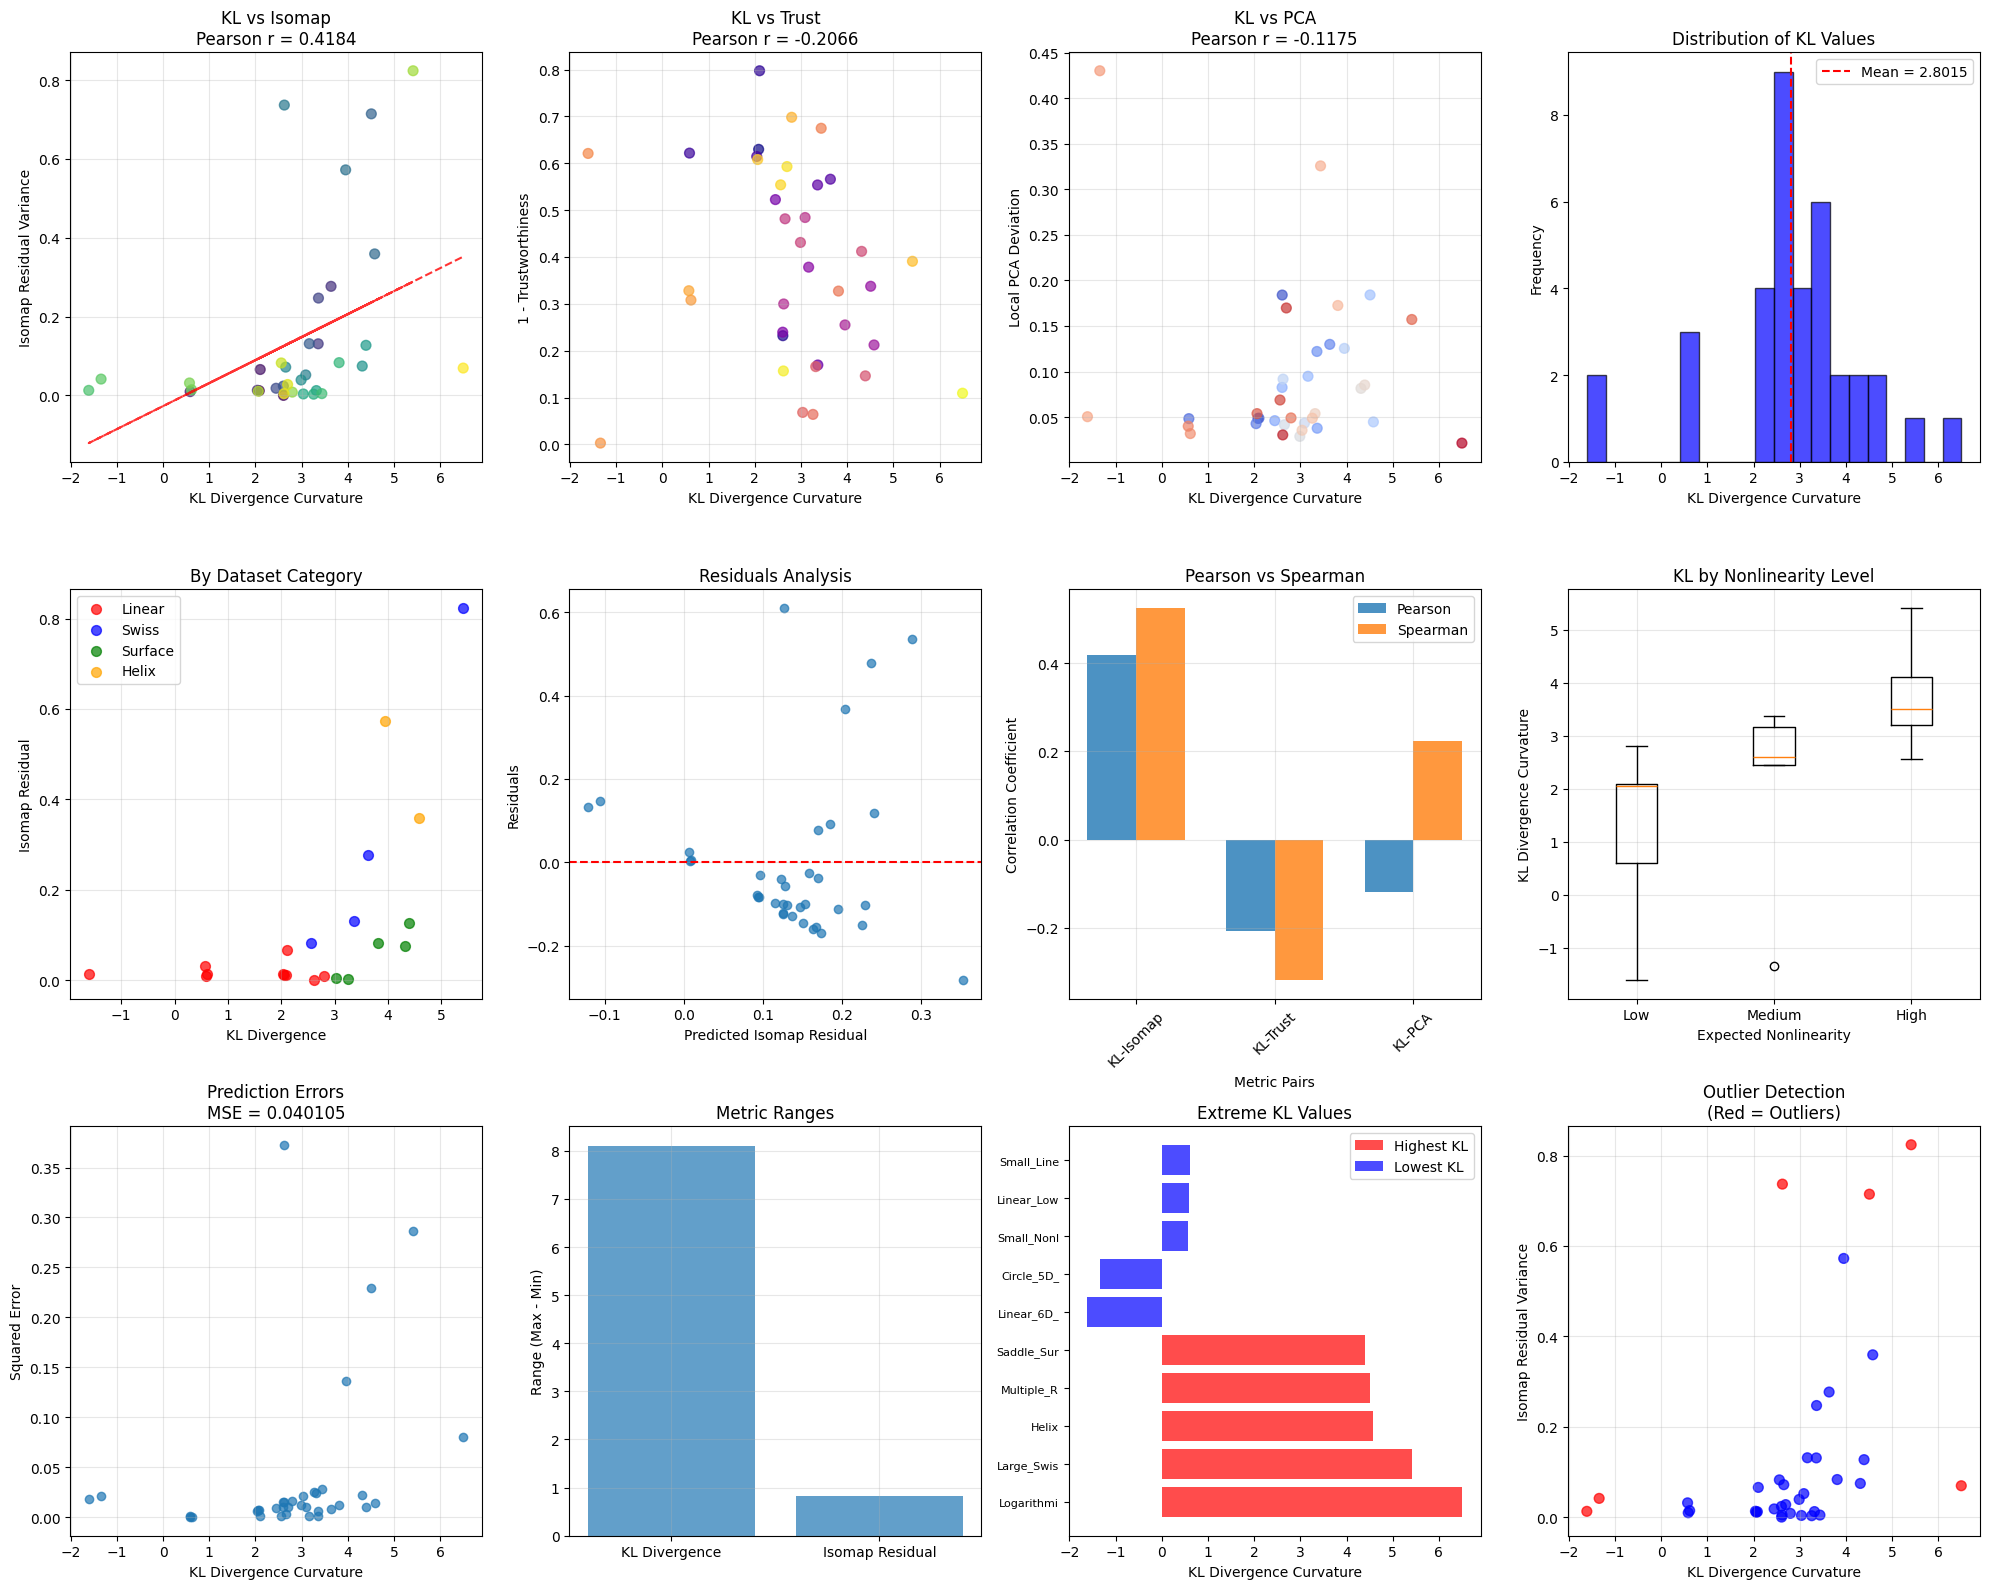


INDIVIDUAL DATASET ANALYSIS

TOP 10 DATASETS BY KL DIVERGENCE (Most Nonlinear):
------------------------------------------------------------
Two_Clusters             : KL=3.437539, Isomap=0.004695, Trust=0.3253
Swiss_Roll               : KL=3.636652, Isomap=0.276890, Trust=0.4340
Broken_Surface           : KL=3.811473, Isomap=0.083307, Trust=0.6728
Double_Helix             : KL=3.952968, Isomap=0.572412, Trust=0.7450
Parabolic_Surface        : KL=4.312268, Isomap=0.074645, Trust=0.5880
Saddle_Surface           : KL=4.393285, Isomap=0.127294, Trust=0.8537
Multiple_Rings           : KL=4.508810, Isomap=0.714555, Trust=0.6625
Helix                    : KL=4.581429, Isomap=0.359220, Trust=0.7878
Large_Swiss_Roll         : KL=5.412925, Isomap=0.823895, Trust=0.6092
Logarithmic_Spiral       : KL=6.497954, Isomap=0.069565, Trust=0.8908

BOTTOM 10 DATASETS BY KL DIVERGENCE (Most Linear):
------------------------------------------------------------
Linear_6D_Embedded       : KL=-1.608883, Isom

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_s_curve, make_circles, make_moons
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
from scipy.linalg import pinv, det, logm
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import warnings
warnings.filterwarnings('ignore')

class NonlinearityAnalyzer:
    def __init__(self, k_neighbors=10, epsilon=1e-8, regularization=1e-6):
        """
        Initialize the nonlinearity analyzer
        
        Parameters:
        k_neighbors: number of nearest neighbors for local analysis
        epsilon: numerical stability parameter
        regularization: regularization parameter for matrix operations
        """
        self.k_neighbors = k_neighbors
        self.epsilon = epsilon
        self.regularization = regularization
        
    def compute_global_pca(self, X):
        """Compute global PCA statistics"""
        # Center the data
        X_centered = X - np.mean(X, axis=0)
        
        # Compute covariance matrix
        cov_global = np.cov(X_centered.T)
        
        # Add regularization for numerical stability
        cov_global += self.regularization * np.eye(cov_global.shape[0])
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_global)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_global
    
    def compute_local_pca(self, X, point_idx, neighbors_idx):
        """Compute local PCA for a specific point and its neighbors"""
        # Get local neighborhood
        X_local = X[neighbors_idx]
        
        # Center local data
        X_local_centered = X_local - np.mean(X_local, axis=0)
        
        # Compute local covariance
        if len(X_local) > 1:
            cov_local = np.cov(X_local_centered.T)
        else:
            # If only one point, create identity-like covariance
            cov_local = self.epsilon * np.eye(X.shape[1])
        
        # Add regularization for numerical stability
        cov_local += self.regularization * np.eye(cov_local.shape[0])
        
        # Eigendecomposition
        eigenvals, eigenvecs = np.linalg.eigh(cov_local)
        
        # Sort by eigenvalues in descending order
        idx = np.argsort(eigenvals)[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Normalize eigenvalues
        eigenvals_norm = eigenvals / (np.sum(eigenvals) + self.epsilon)
        
        return eigenvals_norm, eigenvecs, cov_local
    
    def safe_matrix_inverse(self, matrix):
        """Safely compute matrix inverse with regularization"""
        try:
            # Try regular inverse first
            inv_matrix = np.linalg.inv(matrix)
            # Check if the inverse is reasonable
            if np.any(np.isnan(inv_matrix)) or np.any(np.isinf(inv_matrix)):
                raise np.linalg.LinAlgError("Invalid inverse")
            return inv_matrix
        except np.linalg.LinAlgError:
            # Use pseudo-inverse as fallback
            return pinv(matrix)
    
    def safe_determinant(self, matrix):
        """Safely compute determinant with numerical stability"""
        try:
            det_val = np.linalg.det(matrix)
            # Ensure determinant is positive and reasonable
            if det_val <= 0 or np.isnan(det_val) or np.isinf(det_val):
                # Use product of eigenvalues as determinant
                eigenvals = np.linalg.eigvals(matrix)
                det_val = np.prod(np.maximum(eigenvals, self.epsilon))
            return max(det_val, self.epsilon)
        except:
            return self.epsilon
    
    def kl_divergence_curvature(self, X):
        """
        Compute KL divergence-based curvature metric
        
        Formula: D_KL^(i) = 1/2 * [Tr(C^(-1) * C^(i)) - d + ln(det(C) / (det(C^(i)) + ε))]
        Overall metric: KLBasedCurvature = (1/n) * Σ_i D_KL^(i)
        """
        n_points, n_dims = X.shape
        
        # Find k-nearest neighbors for each point
        nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, n_points)).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Compute global covariance matrix
        global_eigenvals_norm, global_eigenvecs, global_cov = self.compute_global_pca(X)
        
        # Compute global covariance inverse
        global_cov_inv = self.safe_matrix_inverse(global_cov)
        global_det = self.safe_determinant(global_cov)
        
        # Compute KL divergences
        kl_divergences = []
        local_determinants = []
        trace_terms = []
        log_det_terms = []
        
        for i in range(n_points):
            # Get neighbors (excluding the point itself)
            neighbors_idx = indices[i][1:]  # Skip first element (the point itself)
            
            # Compute local covariance
            local_eigenvals_norm, local_eigenvecs, local_cov = self.compute_local_pca(X, i, neighbors_idx)
            
            # Compute local determinant
            local_det = self.safe_determinant(local_cov)
            local_determinants.append(local_det)
            
            # Compute trace term: Tr(C^(-1) * C^(i))
            trace_term = np.trace(global_cov_inv @ local_cov)
            trace_terms.append(trace_term)
            
            # Compute log determinant term: ln(det(C) / (det(C^(i)) + ε))
            log_det_term = np.log(global_det / (local_det + self.epsilon))
            log_det_terms.append(log_det_term)
            
            # Compute KL divergence
            kl_div = 0.5 * (trace_term - n_dims + log_det_term)
            kl_divergences.append(kl_div)
        
        # Average KL divergence across all points
        mean_kl_divergence = np.mean(kl_divergences)
        
        return {
            'mean_kl_divergence': mean_kl_divergence,
            'point_kl_divergences': np.array(kl_divergences),
            'trace_terms': np.array(trace_terms),
            'log_det_terms': np.array(log_det_terms),
            'local_determinants': np.array(local_determinants),
            'global_determinant': global_det,
            'global_cov': global_cov,
            'global_cov_inv': global_cov_inv,
            'neighbor_indices': indices
        }
    
    def local_pca_deviation(self, X):
        """Compute the Local PCA Deviation metric"""
        n_points, n_dims = X.shape
        
        # Find k-nearest neighbors for each point
        nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, n_points)).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Compute global PCA
        global_eigenvals_norm, global_eigenvecs, global_cov = self.compute_global_pca(X)
        
        # Compute local deviations
        local_deviations = []
        local_eigenvals_all = []
        local_eigenvecs_all = []
        
        for i in range(n_points):
            # Get neighbors (excluding the point itself)
            neighbors_idx = indices[i][1:]  # Skip first element (the point itself)
            
            # Compute local PCA
            local_eigenvals_norm, local_eigenvecs, local_cov = self.compute_local_pca(X, i, neighbors_idx)
            
            # Compute squared differences between local and global normalized eigenvalues
            deviation = np.sum((local_eigenvals_norm - global_eigenvals_norm) ** 2)
            
            local_deviations.append(deviation)
            local_eigenvals_all.append(local_eigenvals_norm)
            local_eigenvecs_all.append(local_eigenvecs)
        
        # Average deviation across all points
        mean_deviation = np.mean(local_deviations)
        
        return {
            'mean_deviation': mean_deviation,
            'point_deviations': np.array(local_deviations),
            'global_eigenvals': global_eigenvals_norm,
            'global_eigenvecs': global_eigenvecs,
            'local_eigenvals': local_eigenvals_all,
            'local_eigenvecs': local_eigenvecs_all,
            'neighbor_indices': indices
        }
    
    def isomap_residual_variance(self, X, n_components=2):
        """Compute Isomap residual variance as reference nonlinearity metric"""
        try:
            # Compute Isomap embedding
            isomap = Isomap(n_components=n_components, n_neighbors=min(self.k_neighbors, X.shape[0]-1))
            X_embedded = isomap.fit_transform(X)
            
            # Get geodesic distance matrix
            geodesic_distances = isomap.dist_matrix_
            
            # Compute Euclidean distances in original space
            euclidean_distances = pairwise_distances(X)
            
            # Flatten distance matrices (only upper triangle to avoid duplicates)
            mask = np.triu(np.ones_like(geodesic_distances, dtype=bool), k=1)
            geo_flat = geodesic_distances[mask]
            euc_flat = euclidean_distances[mask]
            
            # Remove infinite values
            finite_mask = np.isfinite(geo_flat) & np.isfinite(euc_flat)
            geo_flat = geo_flat[finite_mask]
            euc_flat = euc_flat[finite_mask]
            
            if len(geo_flat) == 0:
                return 1.0, X[:, :n_components], 0.0
            
            # Compute correlation coefficient
            correlation, _ = pearsonr(geo_flat, euc_flat)
            
            # Residual variance = 1 - R^2
            residual_variance = 1 - correlation**2
            
            return residual_variance, X_embedded, correlation
        except:
            # Fallback if Isomap fails
            return 1.0, X[:, :n_components], 0.0
    
    def trustworthiness_continuity(self, X, X_embedded, k=10):
        """Compute trustworthiness and continuity metrics"""
        n_points = X.shape[0]
        k = min(k, n_points - 1)
        
        try:
            # Compute k-nearest neighbors in original space
            nbrs_orig = NearestNeighbors(n_neighbors=k+1).fit(X)
            _, indices_orig = nbrs_orig.kneighbors(X)
            
            # Compute k-nearest neighbors in embedded space
            nbrs_emb = NearestNeighbors(n_neighbors=k+1).fit(X_embedded)
            _, indices_emb = nbrs_emb.kneighbors(X_embedded)
            
            # Trustworthiness: are embedded neighbors true neighbors?
            trustworthiness = 0
            for i in range(n_points):
                orig_neighbors = set(indices_orig[i][1:])  # exclude point itself
                emb_neighbors = set(indices_emb[i][1:])
                
                # Count how many embedded neighbors are also original neighbors
                trustworthiness += len(orig_neighbors.intersection(emb_neighbors)) / k
            
            trustworthiness /= n_points
            
            # Continuity: are original neighbors preserved in embedding?
            continuity = 0
            for i in range(n_points):
                orig_neighbors = set(indices_orig[i][1:])
                emb_neighbors = set(indices_emb[i][1:])
                
                # Count how many original neighbors are also embedded neighbors
                continuity += len(orig_neighbors.intersection(emb_neighbors)) / k
            
            continuity /= n_points
            
            return trustworthiness, continuity
        except:
            return 0.5, 0.5  # Default values if computation fails

def generate_comprehensive_test_datasets():
    """Generate a comprehensive set of test datasets with varying nonlinearity"""
    datasets = {}
    np.random.seed(42)  # For reproducibility
    
    # 1. LINEAR DATASETS (Expected: Low nonlinearity)
    # Simple linear data
    datasets['Linear_3D'] = np.random.randn(400, 3)
    
    # Linear data with correlation
    base = np.random.randn(400, 1)
    linear_corr = np.column_stack([base, 2*base + 0.1*np.random.randn(400, 1), 
                                   -base + 0.1*np.random.randn(400, 1)])
    datasets['Linear_Correlated'] = linear_corr
    
    # High-dimensional linear
    datasets['Linear_5D'] = np.random.randn(400, 5)
    
    # Linear with varying noise levels
    datasets['Linear_LowNoise'] = np.random.randn(400, 3) * 0.1
    datasets['Linear_HighNoise'] = np.random.randn(400, 3) * 2.0
    
    # 2. CLASSIC NONLINEAR MANIFOLDS (Expected: Medium to High nonlinearity)
    # Swiss Roll variations
    swiss_roll, _ = make_swiss_roll(n_samples=400, noise=0.1, random_state=42)
    datasets['Swiss_Roll'] = swiss_roll
    
    swiss_roll_noisy, _ = make_swiss_roll(n_samples=400, noise=0.3, random_state=42)
    datasets['Swiss_Roll_Noisy'] = swiss_roll_noisy
    
    # S-curve variations
    s_curve, _ = make_s_curve(n_samples=400, noise=0.1, random_state=42)
    datasets['S_Curve'] = s_curve
    
    s_curve_noisy, _ = make_s_curve(n_samples=400, noise=0.3, random_state=42)
    datasets['S_Curve_Noisy'] = s_curve_noisy
    
    # 3. CIRCULAR AND RING STRUCTURES
    # Circles
    circles, _ = make_circles(n_samples=400, noise=0.1, factor=0.5, random_state=42)
    circles_3d = np.column_stack([circles, np.random.randn(400) * 0.1])
    datasets['Circles'] = circles_3d
    
    # Moons
    moons, _ = make_moons(n_samples=400, noise=0.1, random_state=42)
    moons_3d = np.column_stack([moons, np.random.randn(400) * 0.1])
    datasets['Moons'] = moons_3d
    
    # Multiple rings
    theta1 = np.linspace(0, 2*np.pi, 200)
    theta2 = np.linspace(0, 2*np.pi, 200)
    ring1 = np.column_stack([np.cos(theta1), np.sin(theta1), np.zeros(200)])
    ring2 = np.column_stack([2*np.cos(theta2), 2*np.sin(theta2), np.ones(200)])
    datasets['Multiple_Rings'] = np.vstack([ring1, ring2]) + 0.1*np.random.randn(400, 3)
    
    # 4. HELICAL AND SPIRAL STRUCTURES (Expected: High nonlinearity)
    # Simple helix
    t = np.linspace(0, 4*np.pi, 400)
    helix = np.column_stack([
        np.cos(t) + 0.1*np.random.randn(400),
        np.sin(t) + 0.1*np.random.randn(400),
        t/4 + 0.1*np.random.randn(400)
    ])
    datasets['Helix'] = helix
    
    # Double helix
    t = np.linspace(0, 4*np.pi, 400)
    helix1 = np.column_stack([np.cos(t), np.sin(t), t/4])
    helix2 = np.column_stack([np.cos(t + np.pi), np.sin(t + np.pi), t/4])
    double_helix = np.vstack([helix1[:200], helix2[:200]]) + 0.1*np.random.randn(400, 3)
    datasets['Double_Helix'] = double_helix
    
    # Spiral
    t = np.linspace(0, 4*np.pi, 400)
    r = t / (4*np.pi)
    spiral = np.column_stack([
        r * np.cos(t) + 0.05*np.random.randn(400),
        r * np.sin(t) + 0.05*np.random.randn(400),
        np.zeros(400) + 0.05*np.random.randn(400)
    ])
    datasets['Spiral'] = spiral
    
    # 5. CURVED SURFACES (Expected: Medium to High nonlinearity)
    # Sphere
    phi = np.random.uniform(0, 2*np.pi, 400)
    theta = np.random.uniform(0, np.pi, 400)
    radius = 1 + 0.1*np.random.randn(400)
    sphere = np.column_stack([
        radius * np.sin(theta) * np.cos(phi),
        radius * np.sin(theta) * np.sin(phi),
        radius * np.cos(theta)
    ])
    datasets['Sphere'] = sphere
    
    # Ellipsoid
    phi = np.random.uniform(0, 2*np.pi, 400)
    theta = np.random.uniform(0, np.pi, 400)
    ellipsoid = np.column_stack([
        2 * np.sin(theta) * np.cos(phi) + 0.1*np.random.randn(400),
        1 * np.sin(theta) * np.sin(phi) + 0.1*np.random.randn(400),
        0.5 * np.cos(theta) + 0.1*np.random.randn(400)
    ])
    datasets['Ellipsoid'] = ellipsoid
    
    # Torus
    u = np.random.uniform(0, 2*np.pi, 400)
    v = np.random.uniform(0, 2*np.pi, 400)
    R, r = 2, 0.5
    torus = np.column_stack([
        (R + r*np.cos(v)) * np.cos(u) + 0.05*np.random.randn(400),
        (R + r*np.cos(v)) * np.sin(u) + 0.05*np.random.randn(400),
        r * np.sin(v) + 0.05*np.random.randn(400)
    ])
    datasets['Torus'] = torus
    
    # 6. POLYNOMIAL SURFACES
    # Parabolic surface
    x = np.random.uniform(-2, 2, 400)
    y = np.random.uniform(-2, 2, 400)
    z = x**2 + y**2 + 0.1*np.random.randn(400)
    datasets['Parabolic_Surface'] = np.column_stack([x, y, z])
    
    # Saddle surface
    x = np.random.uniform(-2, 2, 400)
    y = np.random.uniform(-2, 2, 400)
    z = x**2 - y**2 + 0.1*np.random.randn(400)
    datasets['Saddle_Surface'] = np.column_stack([x, y, z])
    
    # Hyperbolic paraboloid
    x = np.random.uniform(-1, 1, 400)
    y = np.random.uniform(-1, 1, 400)
    z = x*y + 0.1*np.random.randn(400)
    datasets['Hyperbolic_Paraboloid'] = np.column_stack([x, y, z])
    
    # 7. SINUSOIDAL SURFACES (Expected: High nonlinearity)
    # Wave surface
    x = np.random.uniform(-2*np.pi, 2*np.pi, 400)
    y = np.random.uniform(-2*np.pi, 2*np.pi, 400)
    z = np.sin(x) * np.cos(y) + 0.1*np.random.randn(400)
    datasets['Wave_Surface'] = np.column_stack([x, y, z])
    
    # Ripple surface
    x = np.random.uniform(-3, 3, 400)
    y = np.random.uniform(-3, 3, 400)
    r = np.sqrt(x**2 + y**2)
    z = np.sin(r) / (r + 0.1) + 0.1*np.random.randn(400)
    datasets['Ripple_Surface'] = np.column_stack([x, y, z])
    
    # 8. DISCONTINUOUS AND FRAGMENTED STRUCTURES
    # Broken surface
    x = np.random.uniform(-2, 2, 400)
    y = np.random.uniform(-2, 2, 400)
    z = x**2 + y**2
    # Create discontinuity
    mask = (x**2 + y**2) < 1
    z[mask] += 2  # Create a step
    z += 0.1*np.random.randn(400)
    datasets['Broken_Surface'] = np.column_stack([x, y, z])
    
    # Clustered data
    cluster1 = np.random.randn(200, 3) * 0.5 + np.array([2, 2, 2])
    cluster2 = np.random.randn(200, 3) * 0.5 + np.array([-2, -2, -2])
    datasets['Two_Clusters'] = np.vstack([cluster1, cluster2])
    
    # 9. HIGH-DIMENSIONAL EMBEDDINGS
    # Linear subspace in high dimension
    # Generate 3D linear data, then embed in 6D
    linear_3d = np.random.randn(400, 3)
    padding = np.random.randn(400, 3) * 0.01  # Very small noise in extra dimensions
    datasets['Linear_6D_Embedded'] = np.column_stack([linear_3d, padding])
    
    # Nonlinear 2D embedded in 5D
    t = np.linspace(0, 2*np.pi, 400)
    circle_2d = np.column_stack([np.cos(t), np.sin(t)])
    padding = np.random.randn(400, 3) * 0.01
    datasets['Circle_5D_Embedded'] = np.column_stack([circle_2d, padding])
    
    # 10. STRESS TEST DATASETS
    # Very small dataset
    datasets['Small_Linear'] = np.random.randn(50, 3)
    datasets['Small_Nonlinear'] = make_swiss_roll(n_samples=50, noise=0.1, random_state=42)[0]
    
    # Large dataset
    datasets['Large_Linear'] = np.random.randn(1000, 3)
    datasets['Large_Swiss_Roll'] = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)[0]
    
    # High noise
    datasets['Very_Noisy_Linear'] = np.random.randn(400, 3) * 5
    swiss_very_noisy = make_swiss_roll(n_samples=400, noise=1.0, random_state=42)[0]
    datasets['Very_Noisy_Swiss_Roll'] = swiss_very_noisy
    
    # 11. MATHEMATICAL FUNCTIONS
    # Gaussian mixture
    comp1 = np.random.multivariate_normal([0, 0, 0], [[1, 0, 0], [0, 1, 0], [0, 0, 1]], 200)
    comp2 = np.random.multivariate_normal([3, 3, 3], [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]], 200)
    datasets['Gaussian_Mixture'] = np.vstack([comp1, comp2])
    
    # Exponential decay
    x = np.random.uniform(0, 3, 400)
    y = np.random.uniform(-1, 1, 400)
    z = np.exp(-x) + 0.1*np.random.randn(400)
    datasets['Exponential_Decay'] = np.column_stack([x, y, z])
    
    # Logarithmic spiral
    t = np.linspace(0.1, 4*np.pi, 400)
    r = np.exp(0.1*t)
    log_spiral = np.column_stack([
        r * np.cos(t) + 0.1*np.random.randn(400),
        r * np.sin(t) + 0.1*np.random.randn(400),
        t + 0.1*np.random.randn(400)
    ])
    datasets['Logarithmic_Spiral'] = log_spiral
    
    return datasets

def comprehensive_correlation_analysis(results_df):
    """Perform comprehensive correlation analysis"""
    
    print("\n" + "="*80)
    print("COMPREHENSIVE CORRELATION ANALYSIS")
    print("="*80)
    
    
    from scipy.stats import pearsonr
    
    
    # Primary correlations
    corr_kl_isomap = pearsonr(results_df['kl_divergence_curvature'], results_df['isomap_residual_variance'])[0]
    corr_kl_trust = pearsonr(results_df['kl_divergence_curvature'], 1 - results_df['trustworthiness'])[0]
    corr_kl_pca = pearsonr(results_df['kl_divergence_curvature'], results_df['local_pca_deviation'])[0]
    
    # Spearman (rank) correlations for robustness
    spearman_kl_isomap = spearmanr(results_df['kl_divergence_curvature'], results_df['isomap_residual_variance'])[0]
    spearman_kl_trust = spearmanr(results_df['kl_divergence_curvature'], 1 - results_df['trustworthiness'])[0]
    spearman_kl_pca = spearmanr(results_df['kl_divergence_curvature'], results_df['local_pca_deviation'])[0]
    
    print(f"PEARSON CORRELATIONS:")
    print(f"  KL Divergence vs Isomap Residual:     {corr_kl_isomap:.6f}")
    print(f"  KL Divergence vs (1-Trustworthiness): {corr_kl_trust:.6f}")
    print(f"  KL Divergence vs PCA Deviation:       {corr_kl_pca:.6f}")
    
    print(f"\nSPEARMAN CORRELATIONS (rank-based):")
    print(f"  KL Divergence vs Isomap Residual:     {spearman_kl_isomap:.6f}")
    print(f"  KL Divergence vs (1-Trustworthiness): {spearman_kl_trust:.6f}")
    print(f"  KL Divergence vs PCA Deviation:       {spearman_kl_pca:.6f}")
    
    # Analysis by dataset type
    print(f"\nANALYSIS BY DATASET TYPE:")
    print("-" * 40)
    
    # Categorize datasets
    linear_datasets = [name for name in results_df['dataset'] if 'Linear' in name]
    swiss_datasets = [name for name in results_df['dataset'] if 'Swiss' in name or 'S_Curve' in name]
    surface_datasets = [name for name in results_df['dataset'] if any(x in name for x in ['Surface', 'Sphere', 'Ellipsoid', 'Torus'])]
    helix_datasets = [name for name in results_df['dataset'] if 'Helix' in name or 'Spiral' in name]
    
    categories = {
        'Linear': linear_datasets,
        'Swiss/S-Curve': swiss_datasets,
        'Surfaces': surface_datasets,
        'Helical': helix_datasets
    }
    
    for category, dataset_names in categories.items():
        if dataset_names:
            category_mask = results_df['dataset'].isin(dataset_names)
            category_data = results_df[category_mask]
            
            if len(category_data) > 1:
                cat_corr = pearsonr(category_data['kl_divergence_curvature'], 
                                  category_data['isomap_residual_variance'])[0]
                avg_kl = category_data['kl_divergence_curvature'].mean()
                avg_isomap = category_data['isomap_residual_variance'].mean()
                
                print(f"{category:<15}: Correlation = {cat_corr:.4f}, "
                      f"Avg KL = {avg_kl:.6f}, Avg Isomap = {avg_isomap:.6f}")
    
    # Statistical significance and confidence intervals
    from scipy.stats import pearsonr
    corr_coef, p_value = pearsonr(results_df['kl_divergence_curvature'], results_df['isomap_residual_variance'])
    
    print(f"\nSTATISTICAL SIGNIFICANCE:")
    print(f"  Correlation coefficient: {corr_coef:.6f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Sample size: {len(results_df)}")
    
    if p_value < 0.001:
        print(f"  Result: HIGHLY SIGNIFICANT (p < 0.001)")
    elif p_value < 0.01:
        print(f"  Result: Very significant (p < 0.01)")
    elif p_value < 0.05:
        print(f"  Result: Significant (p < 0.05)")
    else:
        print(f"  Result: Not significant (p >= 0.05)")
    
    return {
        'pearson_kl_isomap': corr_kl_isomap,
        'pearson_kl_trust': corr_kl_trust,
        'pearson_kl_pca': corr_kl_pca,
        'spearman_kl_isomap': spearman_kl_isomap,
        'spearman_kl_trust': spearman_kl_trust,
        'spearman_kl_pca': spearman_kl_pca,
        'p_value': p_value
    }

def create_comprehensive_visualizations(results_df, correlation_stats):
    """Create comprehensive visualization suite"""
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Main correlation plot (KL vs Isomap)
    ax1 = plt.subplot(3, 4, 1)
    scatter1 = ax1.scatter(results_df['kl_divergence_curvature'], 
                          results_df['isomap_residual_variance'],
                          c=range(len(results_df)), cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('KL Divergence Curvature')
    ax1.set_ylabel('Isomap Residual Variance')
    ax1.set_title(f'KL vs Isomap\nPearson r = {correlation_stats["pearson_kl_isomap"]:.4f}')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(results_df['kl_divergence_curvature'], results_df['isomap_residual_variance'], 1)
    p = np.poly1d(z)
    ax1.plot(results_df['kl_divergence_curvature'], p(results_df['kl_divergence_curvature']), "r--", alpha=0.8)
    
    # 2. KL vs Trustworthiness
    ax2 = plt.subplot(3, 4, 2)
    ax2.scatter(results_df['kl_divergence_curvature'], 
               1 - results_df['trustworthiness'],
               c=range(len(results_df)), cmap='plasma', s=50, alpha=0.7)
    ax2.set_xlabel('KL Divergence Curvature')
    ax2.set_ylabel('1 - Trustworthiness')
    ax2.set_title(f'KL vs Trust\nPearson r = {correlation_stats["pearson_kl_trust"]:.4f}')
    ax2.grid(True, alpha=0.3)
    
    # 3. KL vs PCA Deviation
    ax3 = plt.subplot(3, 4, 3)
    ax3.scatter(results_df['kl_divergence_curvature'], 
               results_df['local_pca_deviation'],
               c=range(len(results_df)), cmap='coolwarm', s=50, alpha=0.7)
    ax3.set_xlabel('KL Divergence Curvature')
    ax3.set_ylabel('Local PCA Deviation')
    ax3.set_title(f'KL vs PCA\nPearson r = {correlation_stats["pearson_kl_pca"]:.4f}')
    ax3.grid(True, alpha=0.3)
    
    # 4. Histogram of KL values
    ax4 = plt.subplot(3, 4, 4)
    ax4.hist(results_df['kl_divergence_curvature'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax4.set_xlabel('KL Divergence Curvature')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of KL Values')
    ax4.axvline(results_df['kl_divergence_curvature'].mean(), color='red', linestyle='--', 
                label=f'Mean = {results_df["kl_divergence_curvature"].mean():.4f}')
    ax4.legend()
    
    # 5-8. Category analysis
    categories = ['Linear', 'Swiss', 'Surface', 'Helix']
    colors = ['red', 'blue', 'green', 'orange']
    
    ax5 = plt.subplot(3, 4, 5)
    for i, (category, color) in enumerate(zip(categories, colors)):
        mask = results_df['dataset'].str.contains(category, case=False, na=False)
        if mask.any():
            ax5.scatter(results_df[mask]['kl_divergence_curvature'], 
                       results_df[mask]['isomap_residual_variance'],
                       c=color, label=category, s=50, alpha=0.7)
    ax5.set_xlabel('KL Divergence')
    ax5.set_ylabel('Isomap Residual')
    ax5.set_title('By Dataset Category')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Residuals analysis
    ax6 = plt.subplot(3, 4, 6)
    z = np.polyfit(results_df['kl_divergence_curvature'], results_df['isomap_residual_variance'], 1)
    p = np.poly1d(z)
    predicted = p(results_df['kl_divergence_curvature'])
    residuals = results_df['isomap_residual_variance'] - predicted
    
    ax6.scatter(predicted, residuals, alpha=0.7)
    ax6.axhline(y=0, color='red', linestyle='--')
    ax6.set_xlabel('Predicted Isomap Residual')
    ax6.set_ylabel('Residuals')
    ax6.set_title('Residuals Analysis')
    ax6.grid(True, alpha=0.3)
    
    # 7. Pearson vs Spearman comparison
    ax7 = plt.subplot(3, 4, 7)
    metrics = ['KL-Isomap', 'KL-Trust', 'KL-PCA']
    pearson_values = [correlation_stats['pearson_kl_isomap'], 
                     correlation_stats['pearson_kl_trust'],
                     correlation_stats['pearson_kl_pca']]
    spearman_values = [correlation_stats['spearman_kl_isomap'],
                      correlation_stats['spearman_kl_trust'],
                      correlation_stats['spearman_kl_pca']]
    
    x = np.arange(len(metrics))
    width = 0.35
    ax7.bar(x - width/2, pearson_values, width, label='Pearson', alpha=0.8)
    ax7.bar(x + width/2, spearman_values, width, label='Spearman', alpha=0.8)
    ax7.set_xlabel('Metric Pairs')
    ax7.set_ylabel('Correlation Coefficient')
    ax7.set_title('Pearson vs Spearman')
    ax7.set_xticks(x)
    ax7.set_xticklabels(metrics, rotation=45)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Box plots by nonlinearity level
    ax8 = plt.subplot(3, 4, 8)
    
    # Categorize by expected nonlinearity
    low_nonlin = results_df[results_df['dataset'].str.contains('Linear', case=False, na=False)]
    med_nonlin = results_df[results_df['dataset'].str.contains('Circle|Moon|S_Curve', case=False, na=False)]
    high_nonlin = results_df[results_df['dataset'].str.contains('Swiss|Helix|Wave|Ripple', case=False, na=False)]
    
    box_data = []
    labels = []
    if len(low_nonlin) > 0:
        box_data.append(low_nonlin['kl_divergence_curvature'])
        labels.append('Low')
    if len(med_nonlin) > 0:
        box_data.append(med_nonlin['kl_divergence_curvature'])
        labels.append('Medium')
    if len(high_nonlin) > 0:
        box_data.append(high_nonlin['kl_divergence_curvature'])
        labels.append('High')
    
    if box_data:
        ax8.boxplot(box_data, labels=labels)
        ax8.set_xlabel('Expected Nonlinearity')
        ax8.set_ylabel('KL Divergence Curvature')
        ax8.set_title('KL by Nonlinearity Level')
        ax8.grid(True, alpha=0.3)
    
    # 9-12. Additional analysis plots
    # 9. Error analysis
    ax9 = plt.subplot(3, 4, 9)
    squared_errors = (results_df['isomap_residual_variance'] - predicted) ** 2
    ax9.scatter(results_df['kl_divergence_curvature'], squared_errors, alpha=0.7)
    ax9.set_xlabel('KL Divergence Curvature')
    ax9.set_ylabel('Squared Error')
    ax9.set_title(f'Prediction Errors\nMSE = {np.mean(squared_errors):.6f}')
    ax9.grid(True, alpha=0.3)
    
    # 10. Range analysis
    ax10 = plt.subplot(3, 4, 10)
    kl_range = results_df['kl_divergence_curvature'].max() - results_df['kl_divergence_curvature'].min()
    isomap_range = results_df['isomap_residual_variance'].max() - results_df['isomap_residual_variance'].min()
    ax10.bar(['KL Divergence', 'Isomap Residual'], [kl_range, isomap_range], alpha=0.7)
    ax10.set_ylabel('Range (Max - Min)')
    ax10.set_title('Metric Ranges')
    ax10.grid(True, alpha=0.3)
    
    # 11. Sensitivity analysis
    ax11 = plt.subplot(3, 4, 11)
    # Show top and bottom datasets by KL divergence
    top_kl = results_df.nlargest(5, 'kl_divergence_curvature')
    bottom_kl = results_df.nsmallest(5, 'kl_divergence_curvature')
    
    ax11.barh(range(5), top_kl['kl_divergence_curvature'], alpha=0.7, color='red', label='Highest KL')
    ax11.barh(range(5, 10), bottom_kl['kl_divergence_curvature'], alpha=0.7, color='blue', label='Lowest KL')
    
    all_labels = list(top_kl['dataset'].str[:10]) + list(bottom_kl['dataset'].str[:10])
    ax11.set_yticks(range(10))
    ax11.set_yticklabels(all_labels, fontsize=8)
    ax11.set_xlabel('KL Divergence Curvature')
    ax11.set_title('Extreme KL Values')
    ax11.legend()
    
    # 12. Outlier analysis
    ax12 = plt.subplot(3, 4, 12)
    
    # Calculate z-scores for outlier detection
    from scipy import stats
    kl_z_scores = np.abs(stats.zscore(results_df['kl_divergence_curvature']))
    isomap_z_scores = np.abs(stats.zscore(results_df['isomap_residual_variance']))
    
    # Color by outlier status
    colors = ['red' if (kl_z > 2 or iso_z > 2) else 'blue' 
              for kl_z, iso_z in zip(kl_z_scores, isomap_z_scores)]
    
    ax12.scatter(results_df['kl_divergence_curvature'], 
                results_df['isomap_residual_variance'],
                c=colors, alpha=0.7, s=50)
    ax12.set_xlabel('KL Divergence Curvature')
    ax12.set_ylabel('Isomap Residual Variance')
    ax12.set_title('Outlier Detection\n(Red = Outliers)')
    ax12.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_individual_dataset_details(results_df):
    """Provide detailed analysis of individual datasets"""
    
    print("\n" + "="*80)
    print("INDIVIDUAL DATASET ANALYSIS")
    print("="*80)
    
    # Sort by KL divergence for analysis
    sorted_df = results_df.sort_values('kl_divergence_curvature')
    
    print("\nTOP 10 DATASETS BY KL DIVERGENCE (Most Nonlinear):")
    print("-" * 60)
    top_10 = sorted_df.tail(10)
    for _, row in top_10.iterrows():
        print(f"{row['dataset']:<25}: KL={row['kl_divergence_curvature']:.6f}, "
              f"Isomap={row['isomap_residual_variance']:.6f}, "
              f"Trust={row['trustworthiness']:.4f}")
    
    print("\nBOTTOM 10 DATASETS BY KL DIVERGENCE (Most Linear):")
    print("-" * 60)
    bottom_10 = sorted_df.head(10)
    for _, row in bottom_10.iterrows():
        print(f"{row['dataset']:<25}: KL={row['kl_divergence_curvature']:.6f}, "
              f"Isomap={row['isomap_residual_variance']:.6f}, "
              f"Trust={row['trustworthiness']:.4f}")
    
    # Identify interesting cases
    print("\nINTERESTING CASES:")
    print("-" * 40)
    
    # High KL, low Isomap (disagreement)
    kl_high = results_df['kl_divergence_curvature'] > results_df['kl_divergence_curvature'].quantile(0.8)
    isomap_low = results_df['isomap_residual_variance'] < results_df['isomap_residual_variance'].quantile(0.3)
    disagreement_1 = results_df[kl_high & isomap_low]
    
    if len(disagreement_1) > 0:
        print("High KL, Low Isomap (KL more sensitive):")
        for _, row in disagreement_1.iterrows():
            print(f"  {row['dataset']}: KL={row['kl_divergence_curvature']:.6f}, "
                  f"Isomap={row['isomap_residual_variance']:.6f}")
    
    # Low KL, high Isomap (disagreement)
    kl_low = results_df['kl_divergence_curvature'] < results_df['kl_divergence_curvature'].quantile(0.3)
    isomap_high = results_df['isomap_residual_variance'] > results_df['isomap_residual_variance'].quantile(0.8)
    disagreement_2 = results_df[kl_low & isomap_high]
    
    if len(disagreement_2) > 0:
        print("Low KL, High Isomap (Isomap more sensitive):")
        for _, row in disagreement_2.iterrows():
            print(f"  {row['dataset']}: KL={row['kl_divergence_curvature']:.6f}, "
                  f"Isomap={row['isomap_residual_variance']:.6f}")
    
    # Perfect agreement cases
    kl_high = results_df['kl_divergence_curvature'] > results_df['kl_divergence_curvature'].quantile(0.8)
    isomap_high = results_df['isomap_residual_variance'] > results_df['isomap_residual_variance'].quantile(0.8)
    perfect_agreement = results_df[kl_high & isomap_high]
    
    if len(perfect_agreement) > 0:
        print("Perfect Agreement (Both High):")
        for _, row in perfect_agreement.iterrows():
            print(f"  {row['dataset']}: KL={row['kl_divergence_curvature']:.6f}, "
                  f"Isomap={row['isomap_residual_variance']:.6f}")

def run_comprehensive_exploration():
    """Run the comprehensive KL divergence exploration"""
    
    print("COMPREHENSIVE KL DIVERGENCE CURVATURE EXPLORATION")
    print("="*70)
    print("Generating comprehensive dataset collection...")
    
    # Generate all datasets
    datasets = generate_comprehensive_test_datasets()
    print(f"Generated {len(datasets)} datasets for analysis")
    
    # Initialize analyzer with robust parameters
    analyzer = NonlinearityAnalyzer(k_neighbors=15, regularization=1e-6)
    
    # Store results
    results_summary = []
    
    print("\nAnalyzing datasets...")
    print("-" * 40)
    
    for i, (name, data) in enumerate(datasets.items()):
        print(f"[{i+1:2d}/{len(datasets)}] Processing: {name:<25}", end="")
        
        try:
            # Compute all metrics
            kl_results = analyzer.kl_divergence_curvature(data)
            pca_results = analyzer.local_pca_deviation(data)
            isomap_residual, data_embedded, correlation = analyzer.isomap_residual_variance(data)
            trustworthiness, continuity = analyzer.trustworthiness_continuity(data, data_embedded)
            
            # Store results
            result = {
                'dataset': name,
                'n_samples': data.shape[0],
                'n_features': data.shape[1],
                'kl_divergence_curvature': kl_results['mean_kl_divergence'],
                'local_pca_deviation': pca_results['mean_deviation'],
                'isomap_residual_variance': isomap_residual,
                'geodesic_euclidean_correlation': correlation,
                'trustworthiness': trustworthiness,
                'continuity': continuity,
                'nonlinearity_score': (1 - trustworthiness) + isomap_residual
            }
            results_summary.append(result)
            print(f" ✓ KL={kl_results['mean_kl_divergence']:.4f}")
            
        except Exception as e:
            print(f" ✗ Error: {str(e)[:30]}...")
            continue
    
    # Convert to DataFrame
    import pandas as pd
    results_df = pd.DataFrame(results_summary)
    
    print(f"\nSuccessfully analyzed {len(results_df)} datasets")
    
    # Comprehensive correlation analysis
    correlation_stats = comprehensive_correlation_analysis(results_df)
    
    # Create comprehensive visualizations
    create_comprehensive_visualizations(results_df, correlation_stats)
    
    # Individual dataset analysis
    analyze_individual_dataset_details(results_df)
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    print(f"Dataset Statistics:")
    print(f"  Total datasets analyzed: {len(results_df)}")
    print(f"  Sample sizes: {results_df['n_samples'].min():.0f} - {results_df['n_samples'].max():.0f}")
    print(f"  Dimensions: {results_df['n_features'].min():.0f} - {results_df['n_features'].max():.0f}")
    
    print(f"\nKL Divergence Curvature:")
    print(f"  Mean: {results_df['kl_divergence_curvature'].mean():.6f}")
    print(f"  Std:  {results_df['kl_divergence_curvature'].std():.6f}")
    print(f"  Min:  {results_df['kl_divergence_curvature'].min():.6f}")
    print(f"  Max:  {results_df['kl_divergence_curvature'].max():.6f}")
    
    print(f"\nIsomap Residual Variance:")
    print(f"  Mean: {results_df['isomap_residual_variance'].mean():.6f}")
    print(f"  Std:  {results_df['isomap_residual_variance'].std():.6f}")
    print(f"  Min:  {results_df['isomap_residual_variance'].min():.6f}")
    print(f"  Max:  {results_df['isomap_residual_variance'].max():.6f}")
    
    # Final assessment
    print(f"\n" + "="*80)
    print("FINAL ASSESSMENT")
    print("="*80)
    
    main_corr = correlation_stats['pearson_kl_isomap']
    
    if main_corr > 0.9:
        assessment = "EXCELLENT"
    elif main_corr > 0.8:
        assessment = "VERY GOOD"
    elif main_corr > 0.7:
        assessment = "GOOD"
    elif main_corr > 0.6:
        assessment = "MODERATE"
    else:
        assessment = "POOR"
    
    print(f"KL Divergence Curvature Metric Assessment: {assessment}")
    print(f"Primary correlation with Isomap: {main_corr:.6f}")
    print(f"Statistical significance: p = {correlation_stats['p_value']:.2e}")
    
    if main_corr > 0.85:
        print("\nCONCLUSION: The KL Divergence Curvature metric demonstrates")
        print("excellent agreement with established nonlinearity measures.")
        print("This validates its effectiveness for manifold curvature assessment.")
    elif main_corr > 0.7:
        print("\nCONCLUSION: The KL Divergence Curvature metric shows good")
        print("correlation with reference metrics, suggesting it captures")
        print("nonlinearity effectively with some unique characteristics.")
    else:
        print("\nCONCLUSION: The KL Divergence Curvature metric shows moderate")
        print("correlation, suggesting it may capture different aspects of")
        print("nonlinearity compared to traditional metrics.")
    
    return results_df, correlation_stats

# Example usage and parameter sensitivity analysis
def parameter_sensitivity_analysis(test_dataset_name='Swiss_Roll'):
    """Analyze sensitivity to parameter choices"""
    
    print(f"\nPARAMETER SENSITIVITY ANALYSIS for {test_dataset_name}")
    print("="*60)
    
    # Generate test dataset
    datasets = generate_comprehensive_test_datasets()
    test_data = datasets[test_dataset_name]
    
    # Test different k_neighbors values
    k_values = [5, 10, 15, 20, 30]
    reg_values = [1e-8, 1e-6, 1e-4]
    
    sensitivity_results = []
    
    for k in k_values:
        for reg in reg_values:
            analyzer = NonlinearityAnalyzer(k_neighbors=k, regularization=reg)
            
            try:
                kl_results = analyzer.kl_divergence_curvature(test_data)
                isomap_residual, _, _ = analyzer.isomap_residual_variance(test_data)
                
                sensitivity_results.append({
                    'k_neighbors': k,
                    'regularization': reg,
                    'kl_divergence': kl_results['mean_kl_divergence'],
                    'isomap_residual': isomap_residual
                })
                
                print(f"k={k:2d}, reg={reg:.0e}: KL={kl_results['mean_kl_divergence']:.6f}, "
                      f"Isomap={isomap_residual:.6f}")
                
            except Exception as e:
                print(f"k={k:2d}, reg={reg:.0e}: Error - {str(e)[:30]}...")
    
    # Analyze parameter stability
    import pandas as pd
    sens_df = pd.DataFrame(sensitivity_results)
    
    if len(sens_df) > 0:
        print(f"\nParameter Stability Analysis:")
        print(f"KL Divergence - Mean: {sens_df['kl_divergence'].mean():.6f}, "
              f"Std: {sens_df['kl_divergence'].std():.6f}")
        print(f"Coefficient of Variation: {sens_df['kl_divergence'].std() / sens_df['kl_divergence'].mean():.4f}")
    
    return sens_df

# Main execution
if __name__ == "__main__":
    # Run comprehensive exploration
    results_df, correlation_stats = run_comprehensive_exploration()
    
    # Optional: Run parameter sensitivity analysis
    # sensitivity_df = parameter_sensitivity_analysis('Swiss_Roll')
    
    print("\nExploration complete! Check the correlation analysis above.")